In [1]:
from scipy.integrate import odeint
from scipy.optimize import minimize_scalar,minimize
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
import pandas as pd
from scipy import stats
from multiprocessing import Process,Queue,Pool
import matplotlib
matplotlib.rcParams['figure.dpi'] = 500
import pickle as pkl
import importlib
from matplotlib.backends.backend_pdf import PdfPages
import sys
sys.path.append("../src/")
from flux_finding_mp import *
rd.seed(1000)
np.random.seed(1000)
from functools import partial
import seaborn as sb
from sklearn.metrics import r2_score

SyntaxError: invalid syntax (flux_finding_mp.py, line 126)

In [ ]:
numCores = 20
numBestFitIters = 5
numSims = 100
ts = np.linspace(0,30,100)

In [ ]:
data,lacE,glycolysis,fluxes,conc,c0s,vhvds = generateSyntheticData(ts)
print(conc)
print(vhvds)
conc = {key:val for key,val in conc.items() if key != "NADH"}
data

In [ ]:
for col in ["UL_lac","UL_g3p","UL_malate","UL_nadh","UL_gap"]:
    plt.plot(ts,data[col],label=col)
plt.legend()
print(c0s)
print(lacE,glycolysis)
print(fluxes)
print(conc)

In [5]:
fluxes_inferred,C0s_inferred,df,conc,error = findFlux(data, ts, conc, lacE, glycolysis,vhvds, np.array([0,0,0,0]))
print(fluxes_inferred)
print(C0s_inferred)
print(conc)
print(error)
df

1.0


c:\users\ethan\appdata\local\programs\python\python37\lib\site-packages\scipy\integrate\odepack.py:247: ODEintWarning: Repeated convergence failures (perhaps bad Jacobian or tolerances). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


[0.4303125  0.087125   0.625      0.72395421]
[0.91190921 0.58434071 0.32879576 0.57805216]
{'Lactate': 0.9526443992215418, 'G3P': 0.9311434346775108, 'Malate': 0.41543095304490785, 'NADH': 0.029199218749999138}
[4.88820203e-09 1.25082921e-04 1.47224285e-09 3.56501616e-11]


,UL_lac,UL_g3p,UL_malate,UL_nadh,UL_gap,L_lac,L_malate,L_nadh,L_gap,L_g3p_M+1,L_g3p_M+2,L_g3p
0,1.000000,1.000000,1.000000,34.247492,1.000000,0.000000,0.000000,-33.247492,0.000000,0.000000,0.000000,0.000000
1,2.913838,1.452509,6.110767,0.983989,0.972019,-1.913838,-5.110767,0.016011,0.027981,0.000533,0.000004,-0.452509
2,2.470164,1.430834,3.779974,0.967015,0.945754,-1.470164,-2.779974,0.032985,0.054246,0.002056,0.000029,-0.430834
3,2.126685,1.409000,2.502632,0.951303,0.921098,-1.126685,-1.502632,0.048697,0.078902,0.004449,0.000095,-0.409000
4,1.860464,1.387105,1.800472,0.936554,0.897954,-0.860464,-0.800472,0.063446,0.102046,0.007588,0.000215,-0.387105
...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.849197,0.633992,0.782912,0.711451,0.544647,0.150803,0.217088,0.288549,0.455353,0.312621,0.081842,0.366008
96,0.849167,0.633086,0.782875,0.711407,0.544578,0.150833,0.217125,0.288593,0.455422,0.313303,0.082152,0.366914
97,0.849139,0.632218,0.782841,0.711366,0.544514,0.150861,0.217159,0.288634,0.455486,0.313962,0.082452,0.367782
98,0.849112,0.631387,0.782808,0.711328,0.544453,0.150888,0.217192,0.288672,0.455547,0.314598,0.082743,0.368613


In [6]:
dhap_params = fitSource(ts, data["UL_gap"])
dhap = lambda x: exponetialCurve(x,dhap_params)

    
firstT = np.min(ts)
firstT = [x for x in range(len(ts)) if abs(firstT-ts[x]) < 1e-5]
initialState = [np.mean(data.loc[firstT,label])*c for label,c in zip(["UL_lac","UL_g3p","UL_malate","UL_nadh"],[conc["Lactate"],conc["G3P"],conc["Malate"],conc["NADH"]])]


nadh = interp1d(ts,
                integrateModel(nadhEquation,ts,(fluxes_inferred[3],conc['NADH'],C0s_inferred[3] * fluxes_inferred[3],None,dhap,vhvds),initialState[3],conc["NADH"])[:,0],
                bounds_error=False,fill_value="extrapolate") 


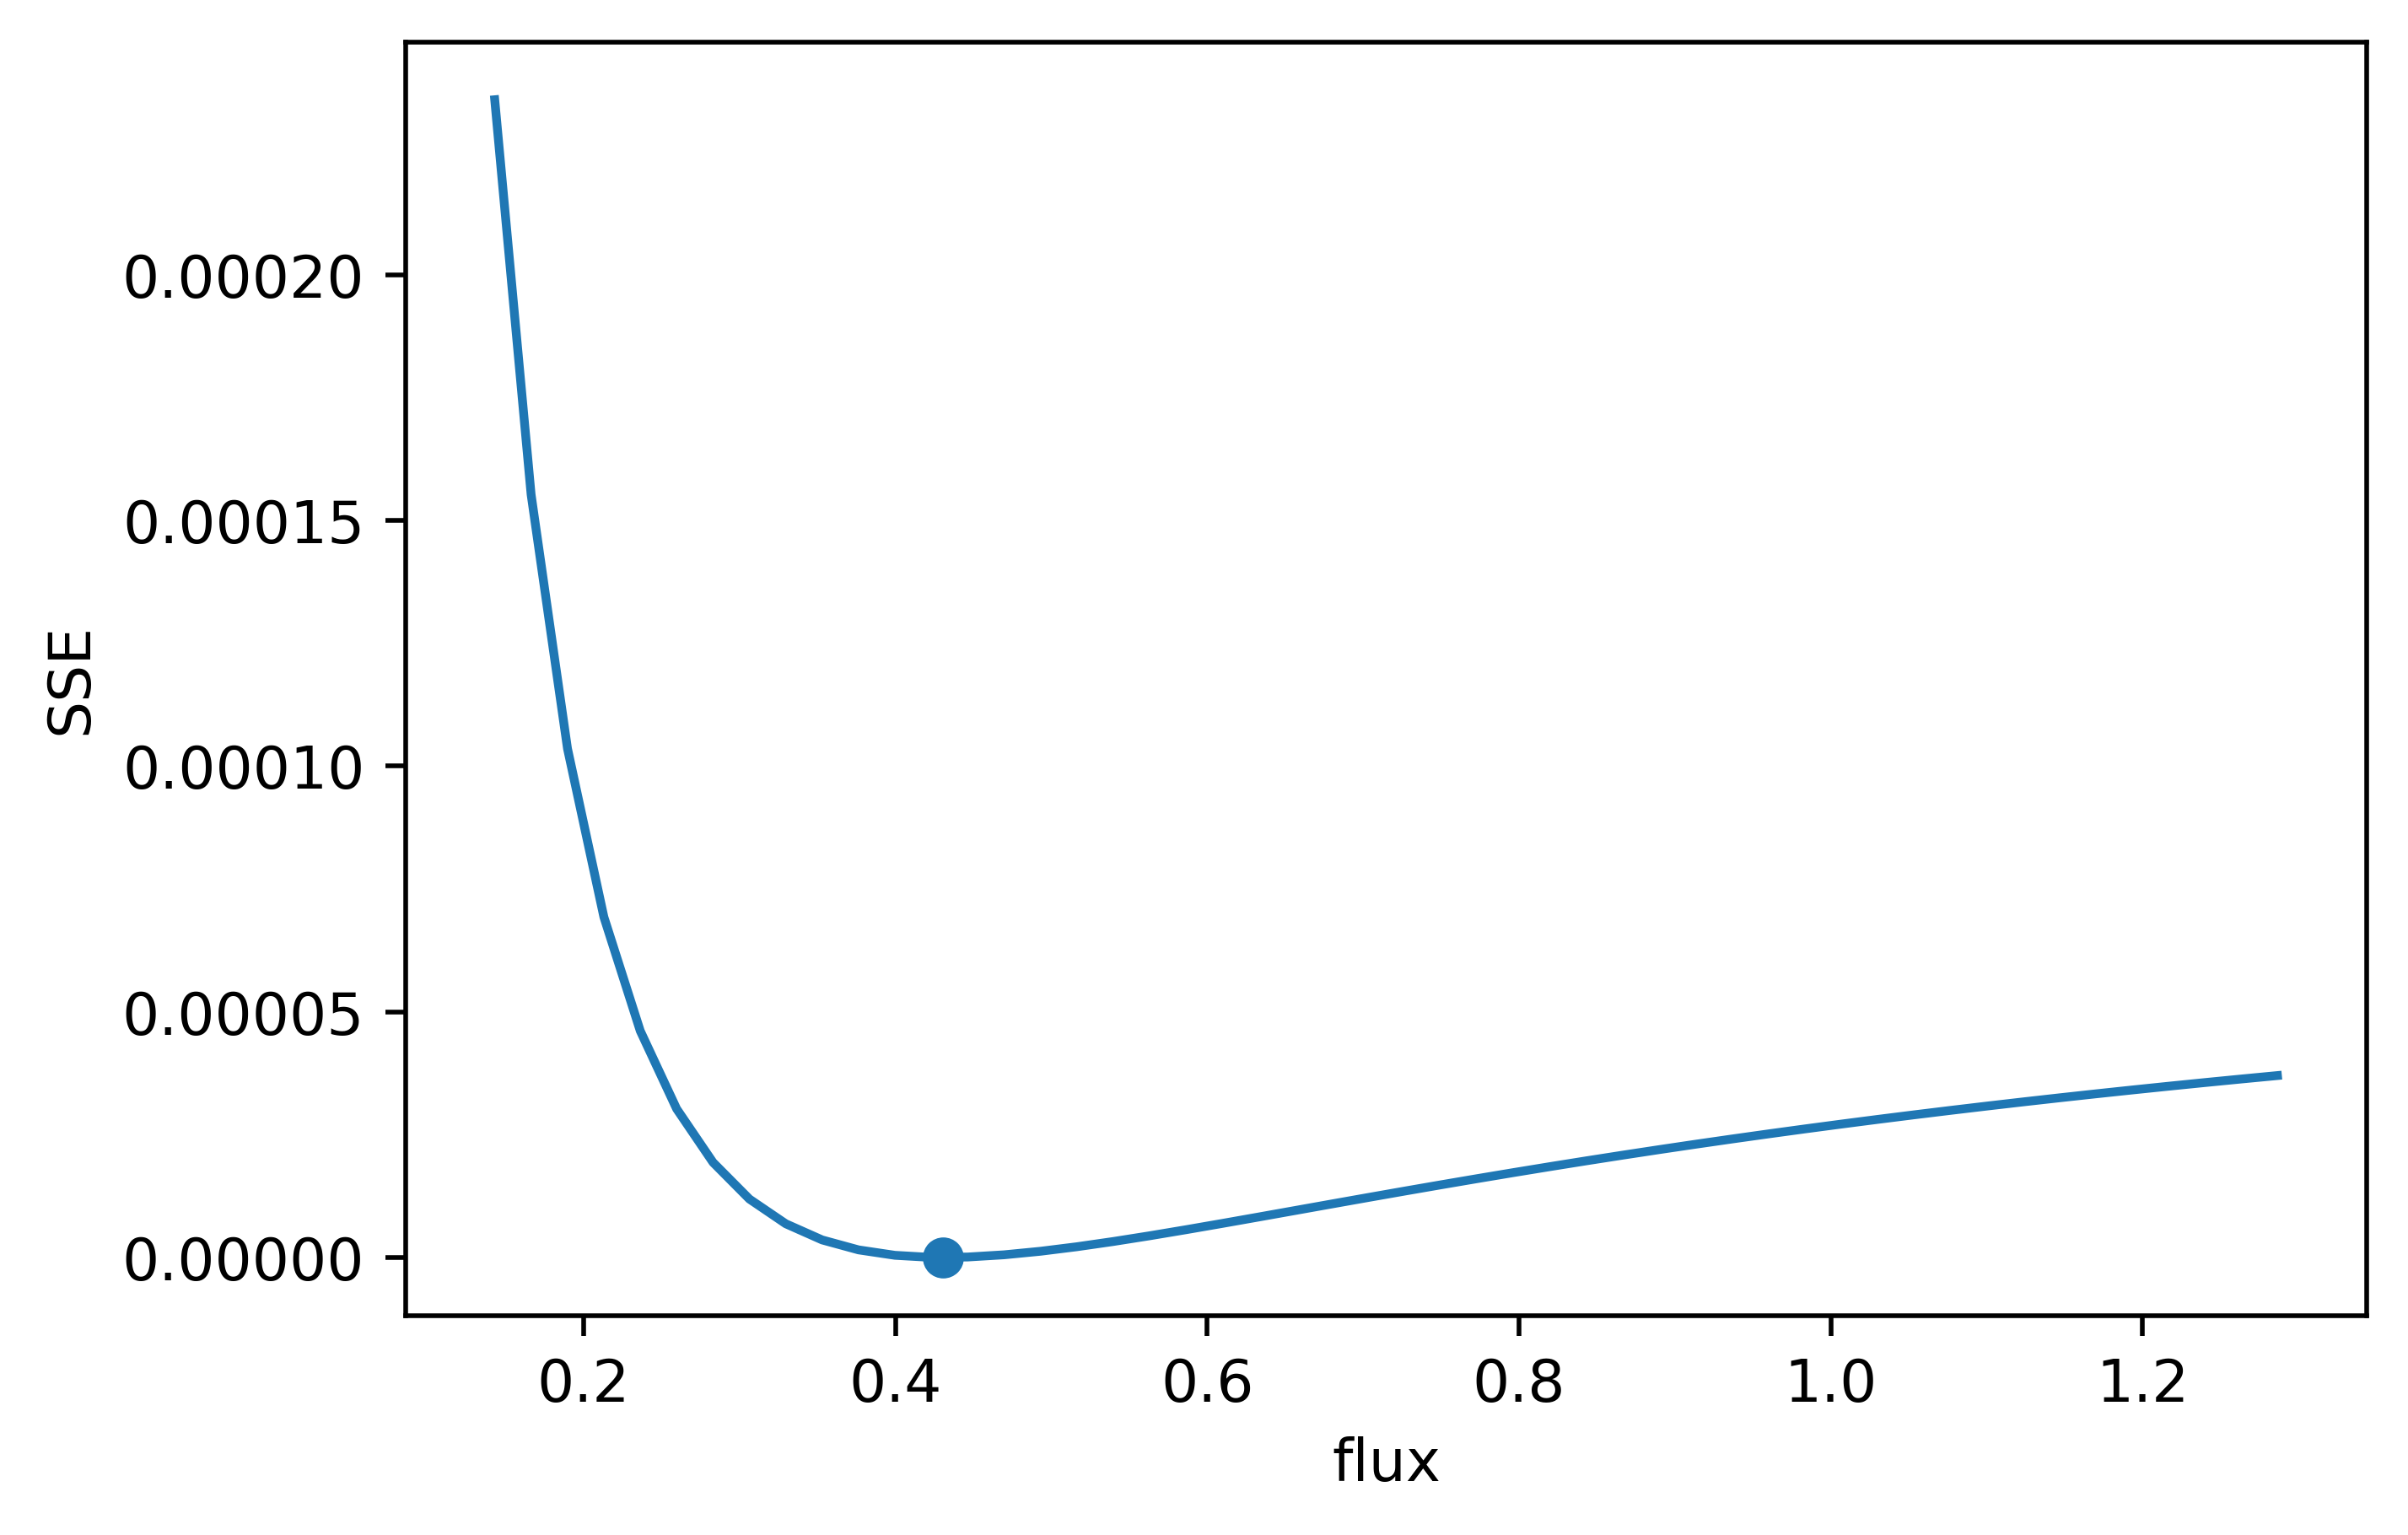

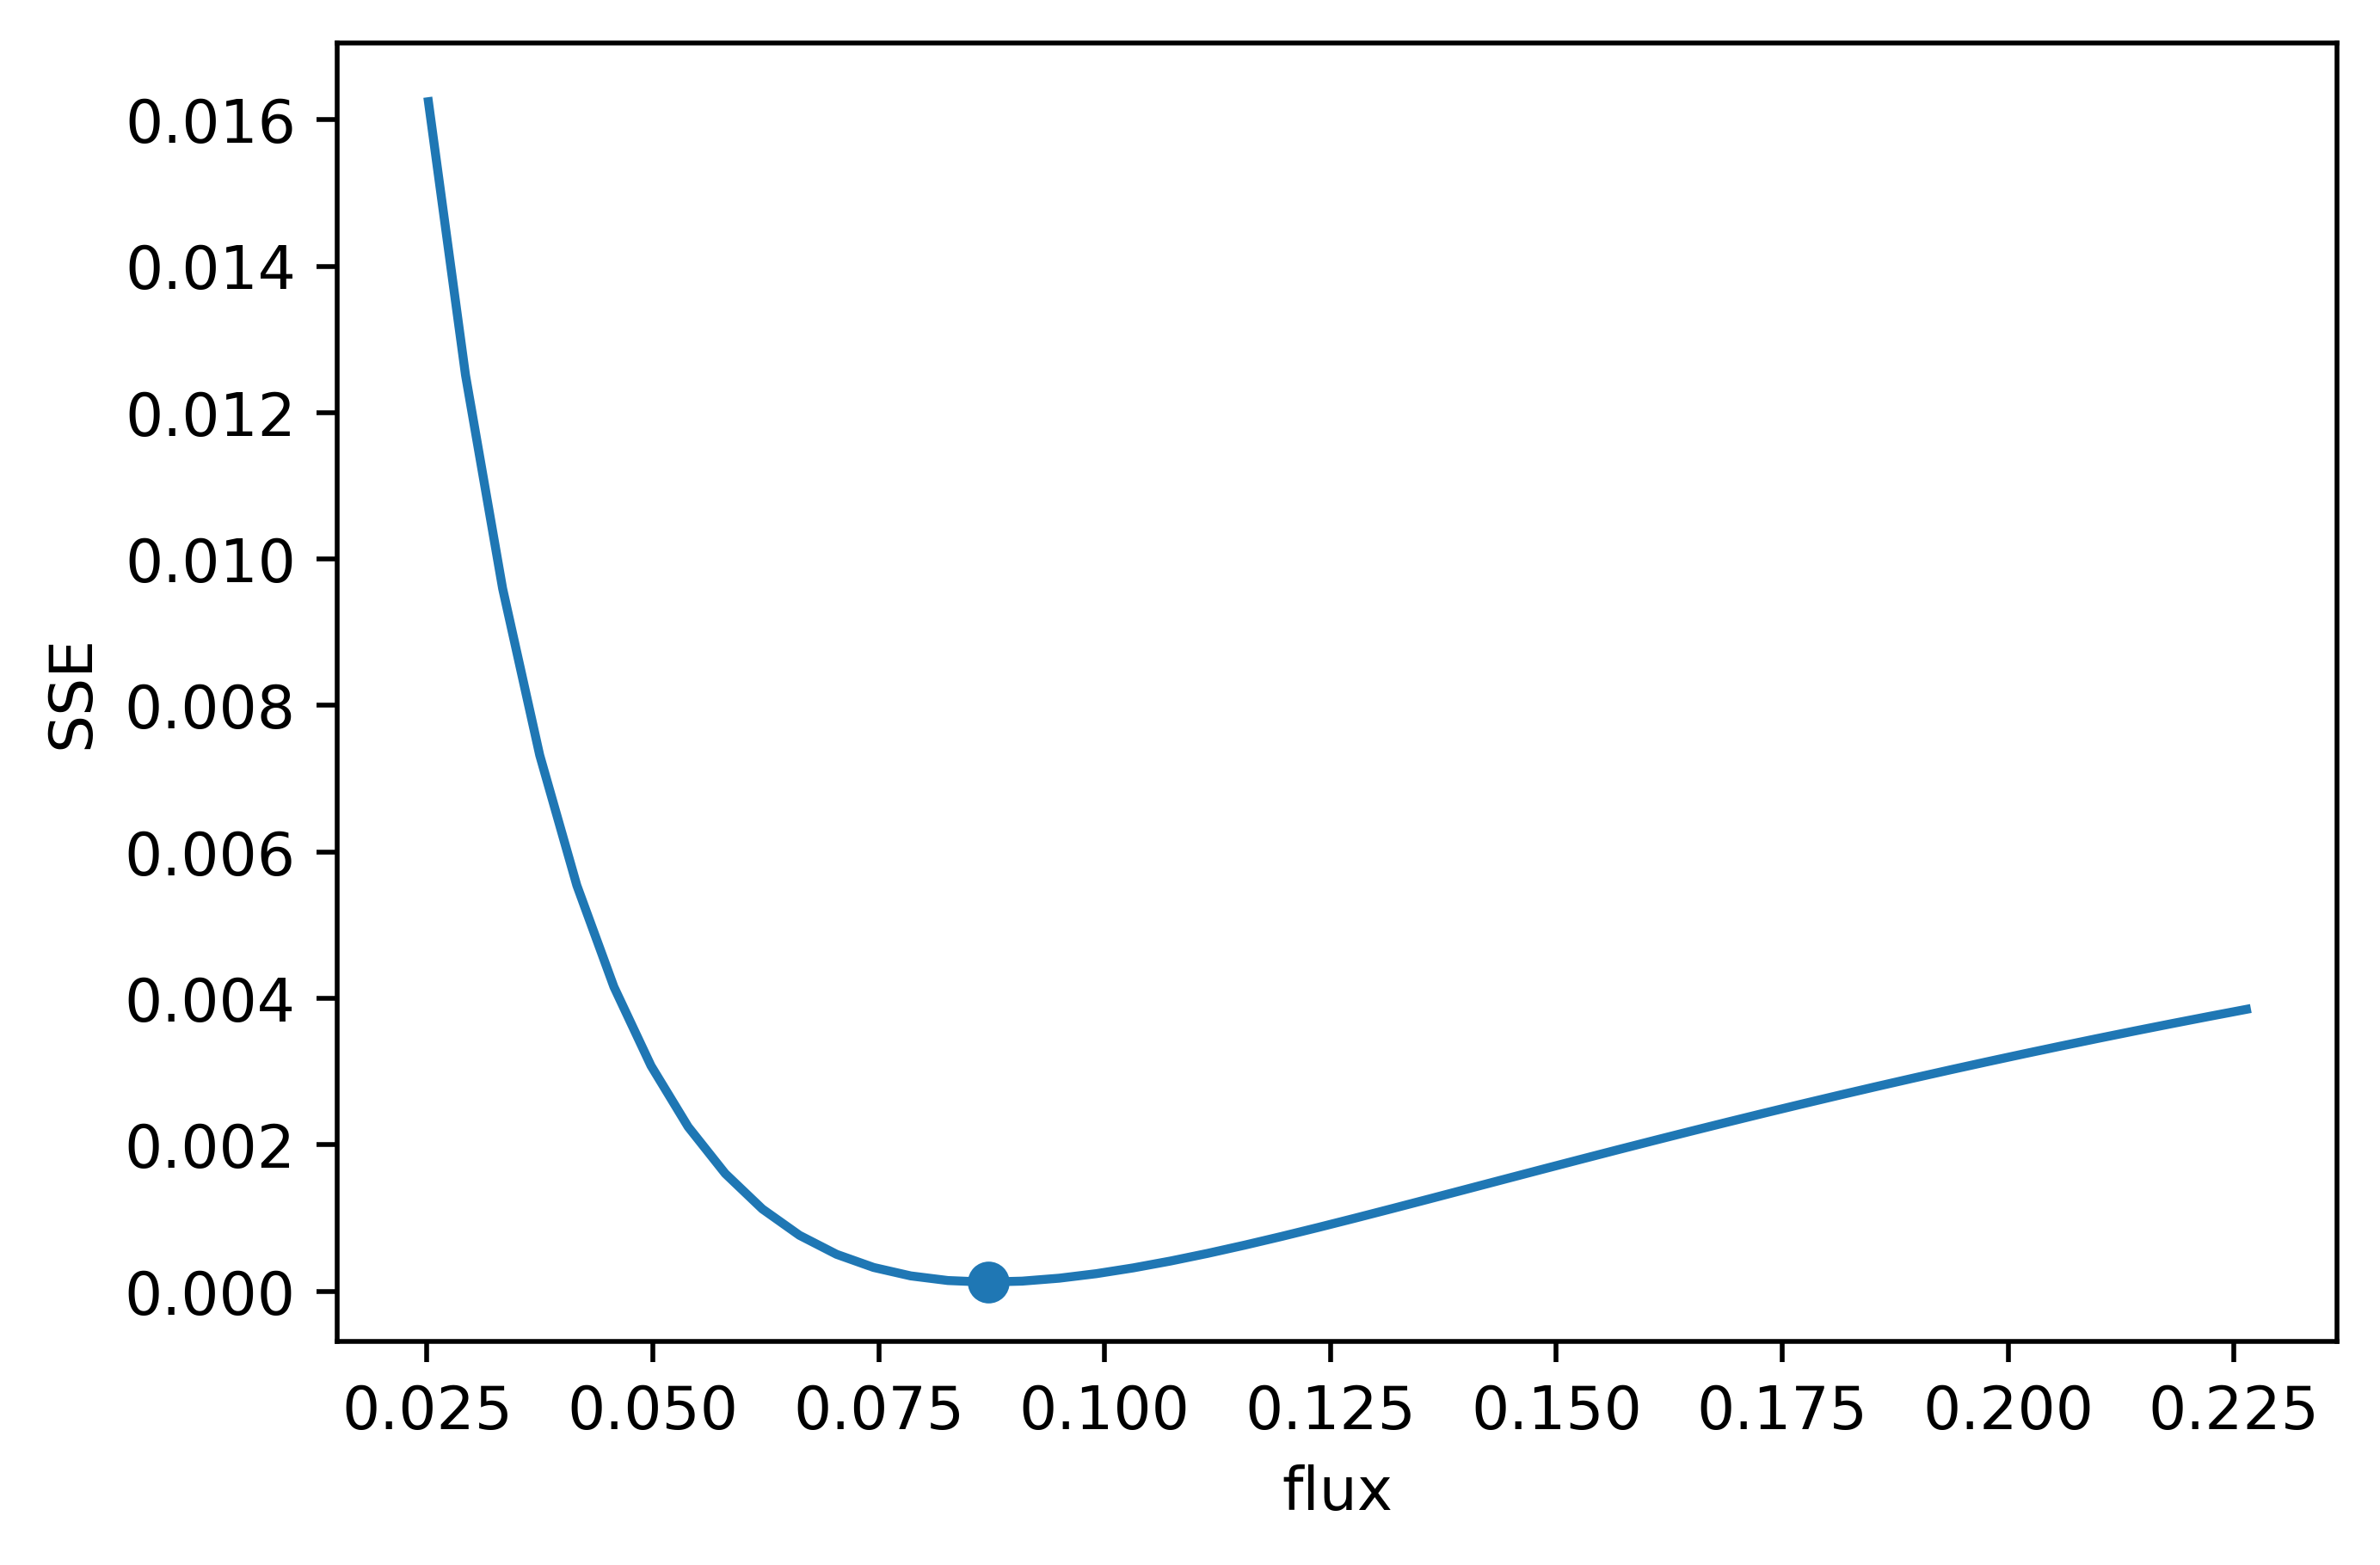

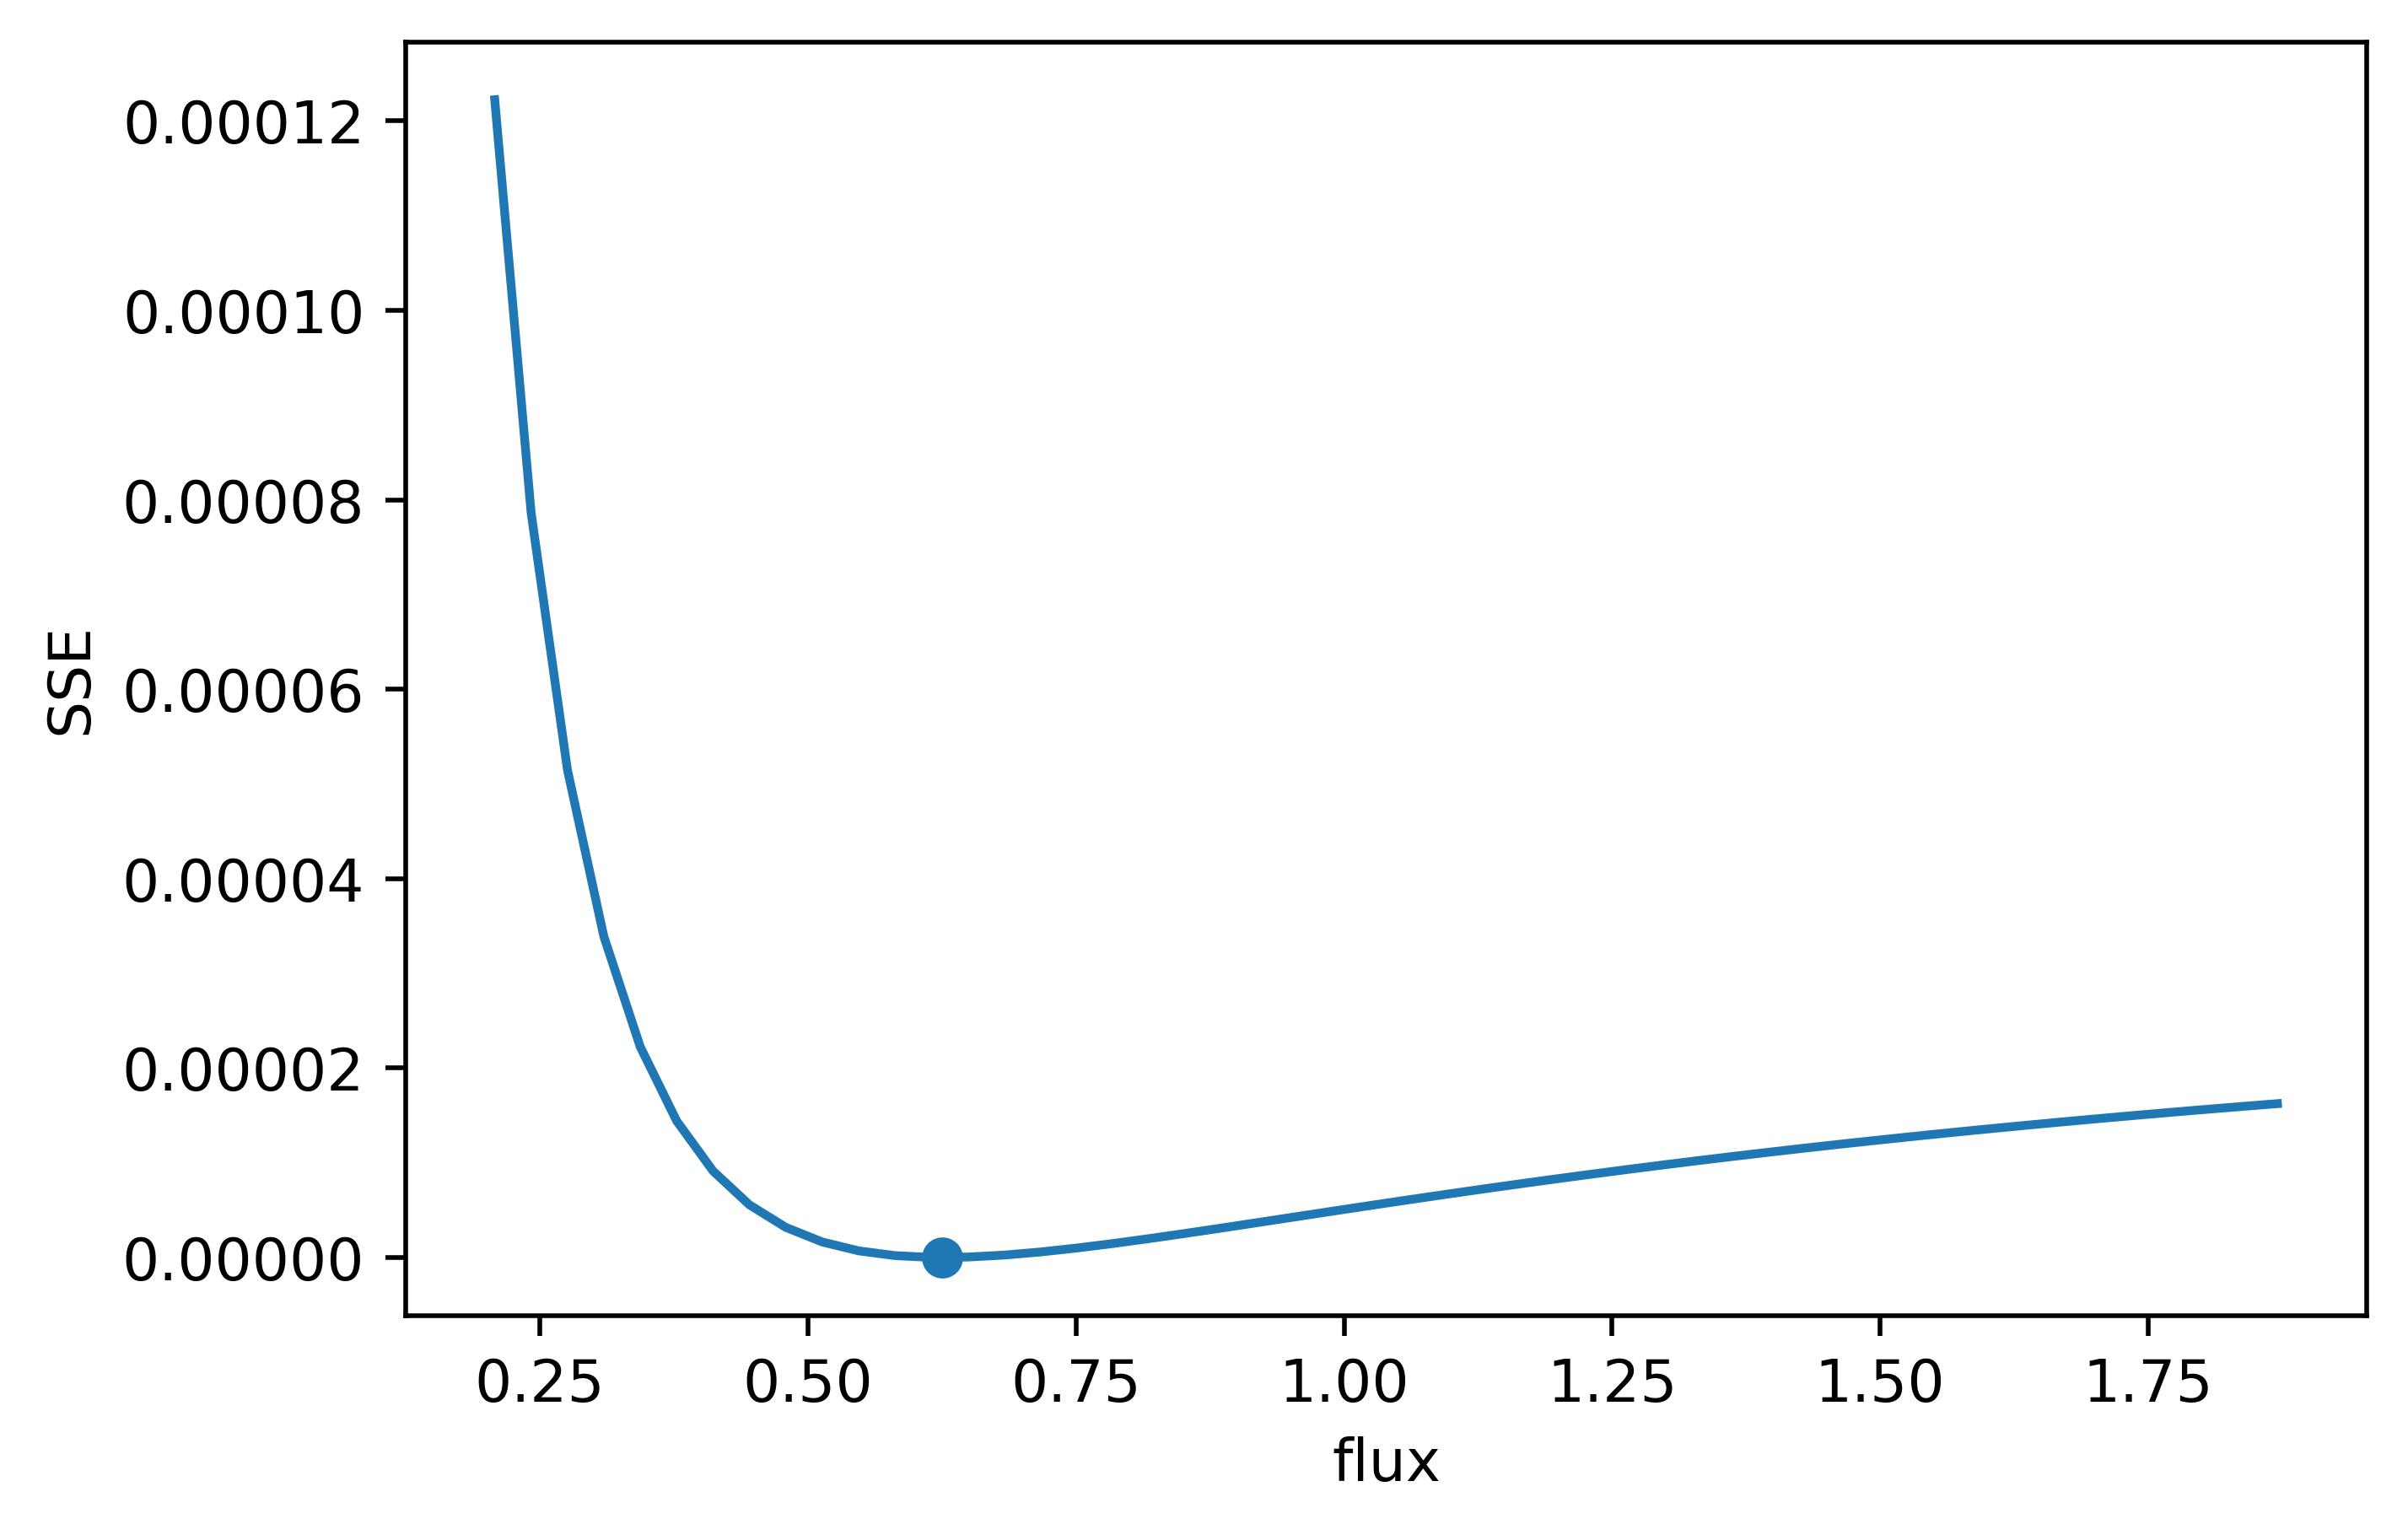

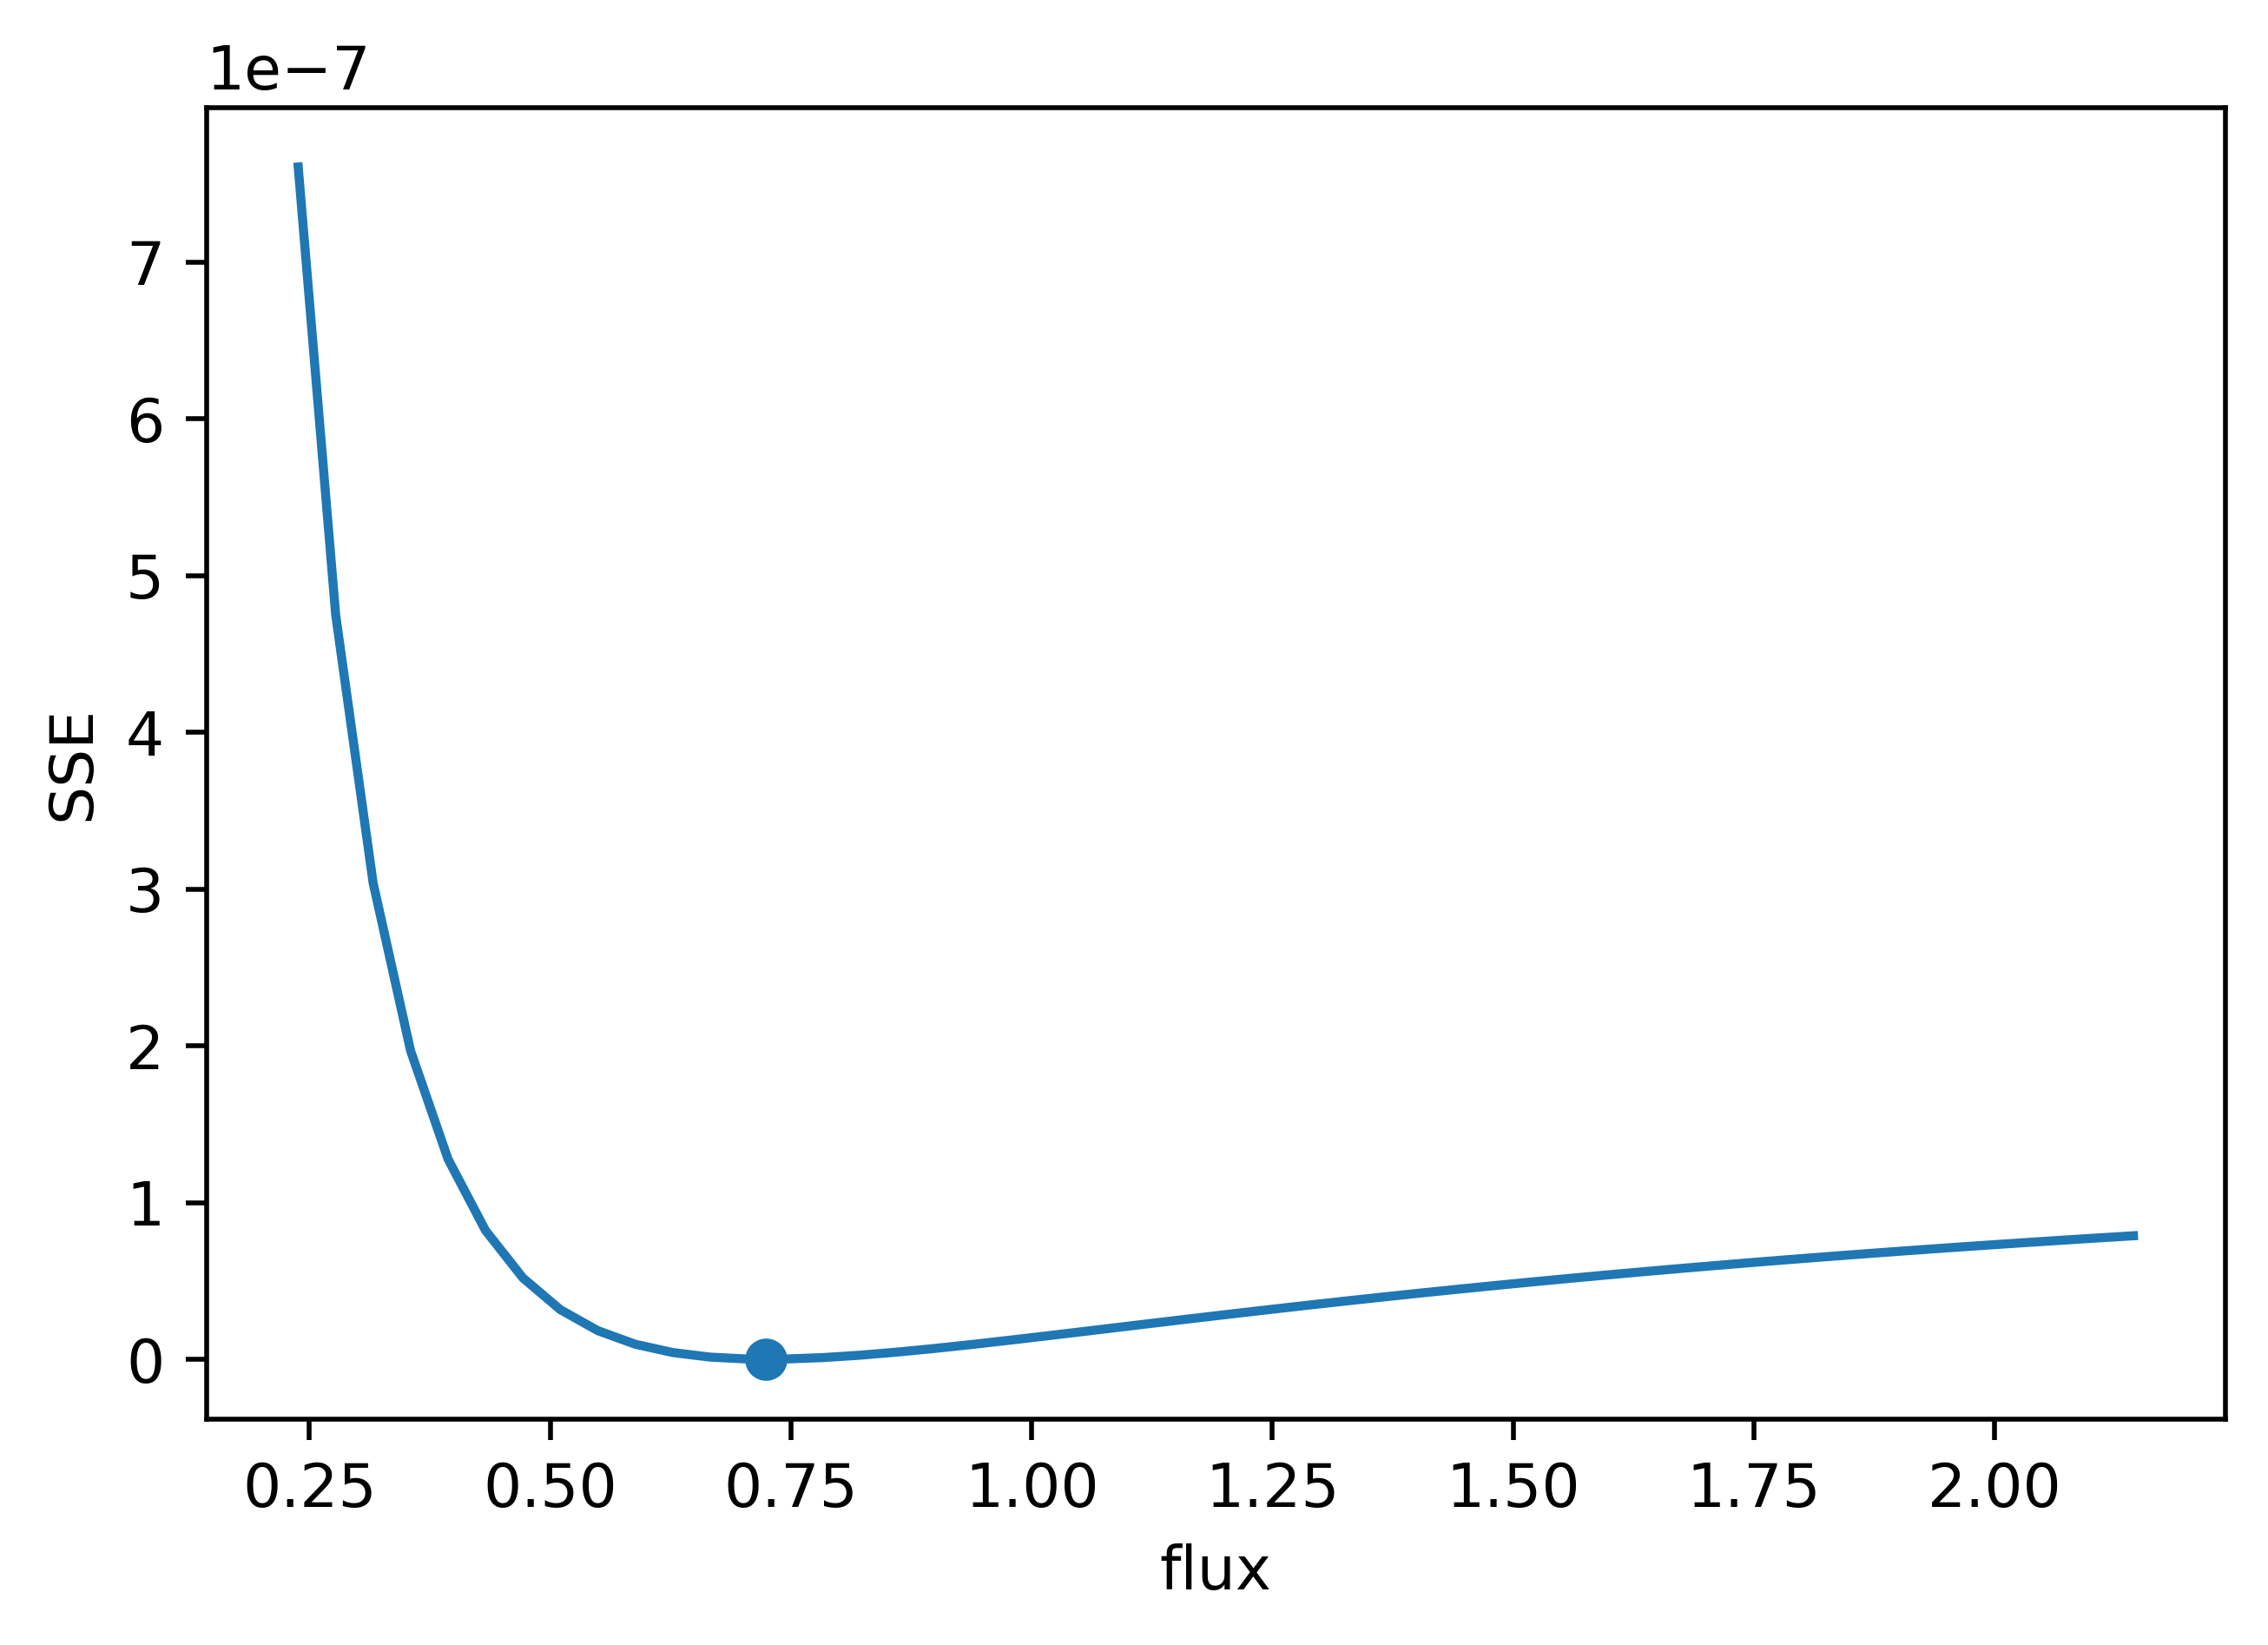

In [7]:
equations = [lactateEquation,g3pEquation,malateEquation,nadhEquation]
labels1 = ["UL_lac","UL_g3p","UL_malate","UL_nadh"]
labels2 = ["Lactate","G3P","Malate","NADH"]
for x in range(4):
    fluxes_to_try = np.linspace(fluxes[x]/3,3*fluxes[x])
    #fluxes_to_try = np.linspace(0,2*fluxes_inferred[x])
    errs = []
    for f in fluxes_to_try:
        val = integrateModel(equations[x],ts,(f,conc[labels2[x]],C0s_inferred[x] * f,nadh,dhap,vhvds),initialState[x],conc[labels2[x]])[:,0]
        err = sse(val,data[labels1[x]].values)#np.sum(np.abs(val-data["UL_nadh"].values))
        errs.append(err)
    f = fluxes_inferred[x]
    val = integrateModel(equations[x],ts,(f,conc[labels2[x]],C0s_inferred[x] * f,nadh,dhap,vhvds),initialState[x],conc[labels2[x]])[:,0]
    err = sse(val,data[labels1[x]].values)
    plt.figure()
    plt.plot(fluxes_to_try,errs)
    plt.ylabel("SSE")
    plt.xlabel("flux")
    plt.scatter([f],[err])
#plt.xlim((0,20000))

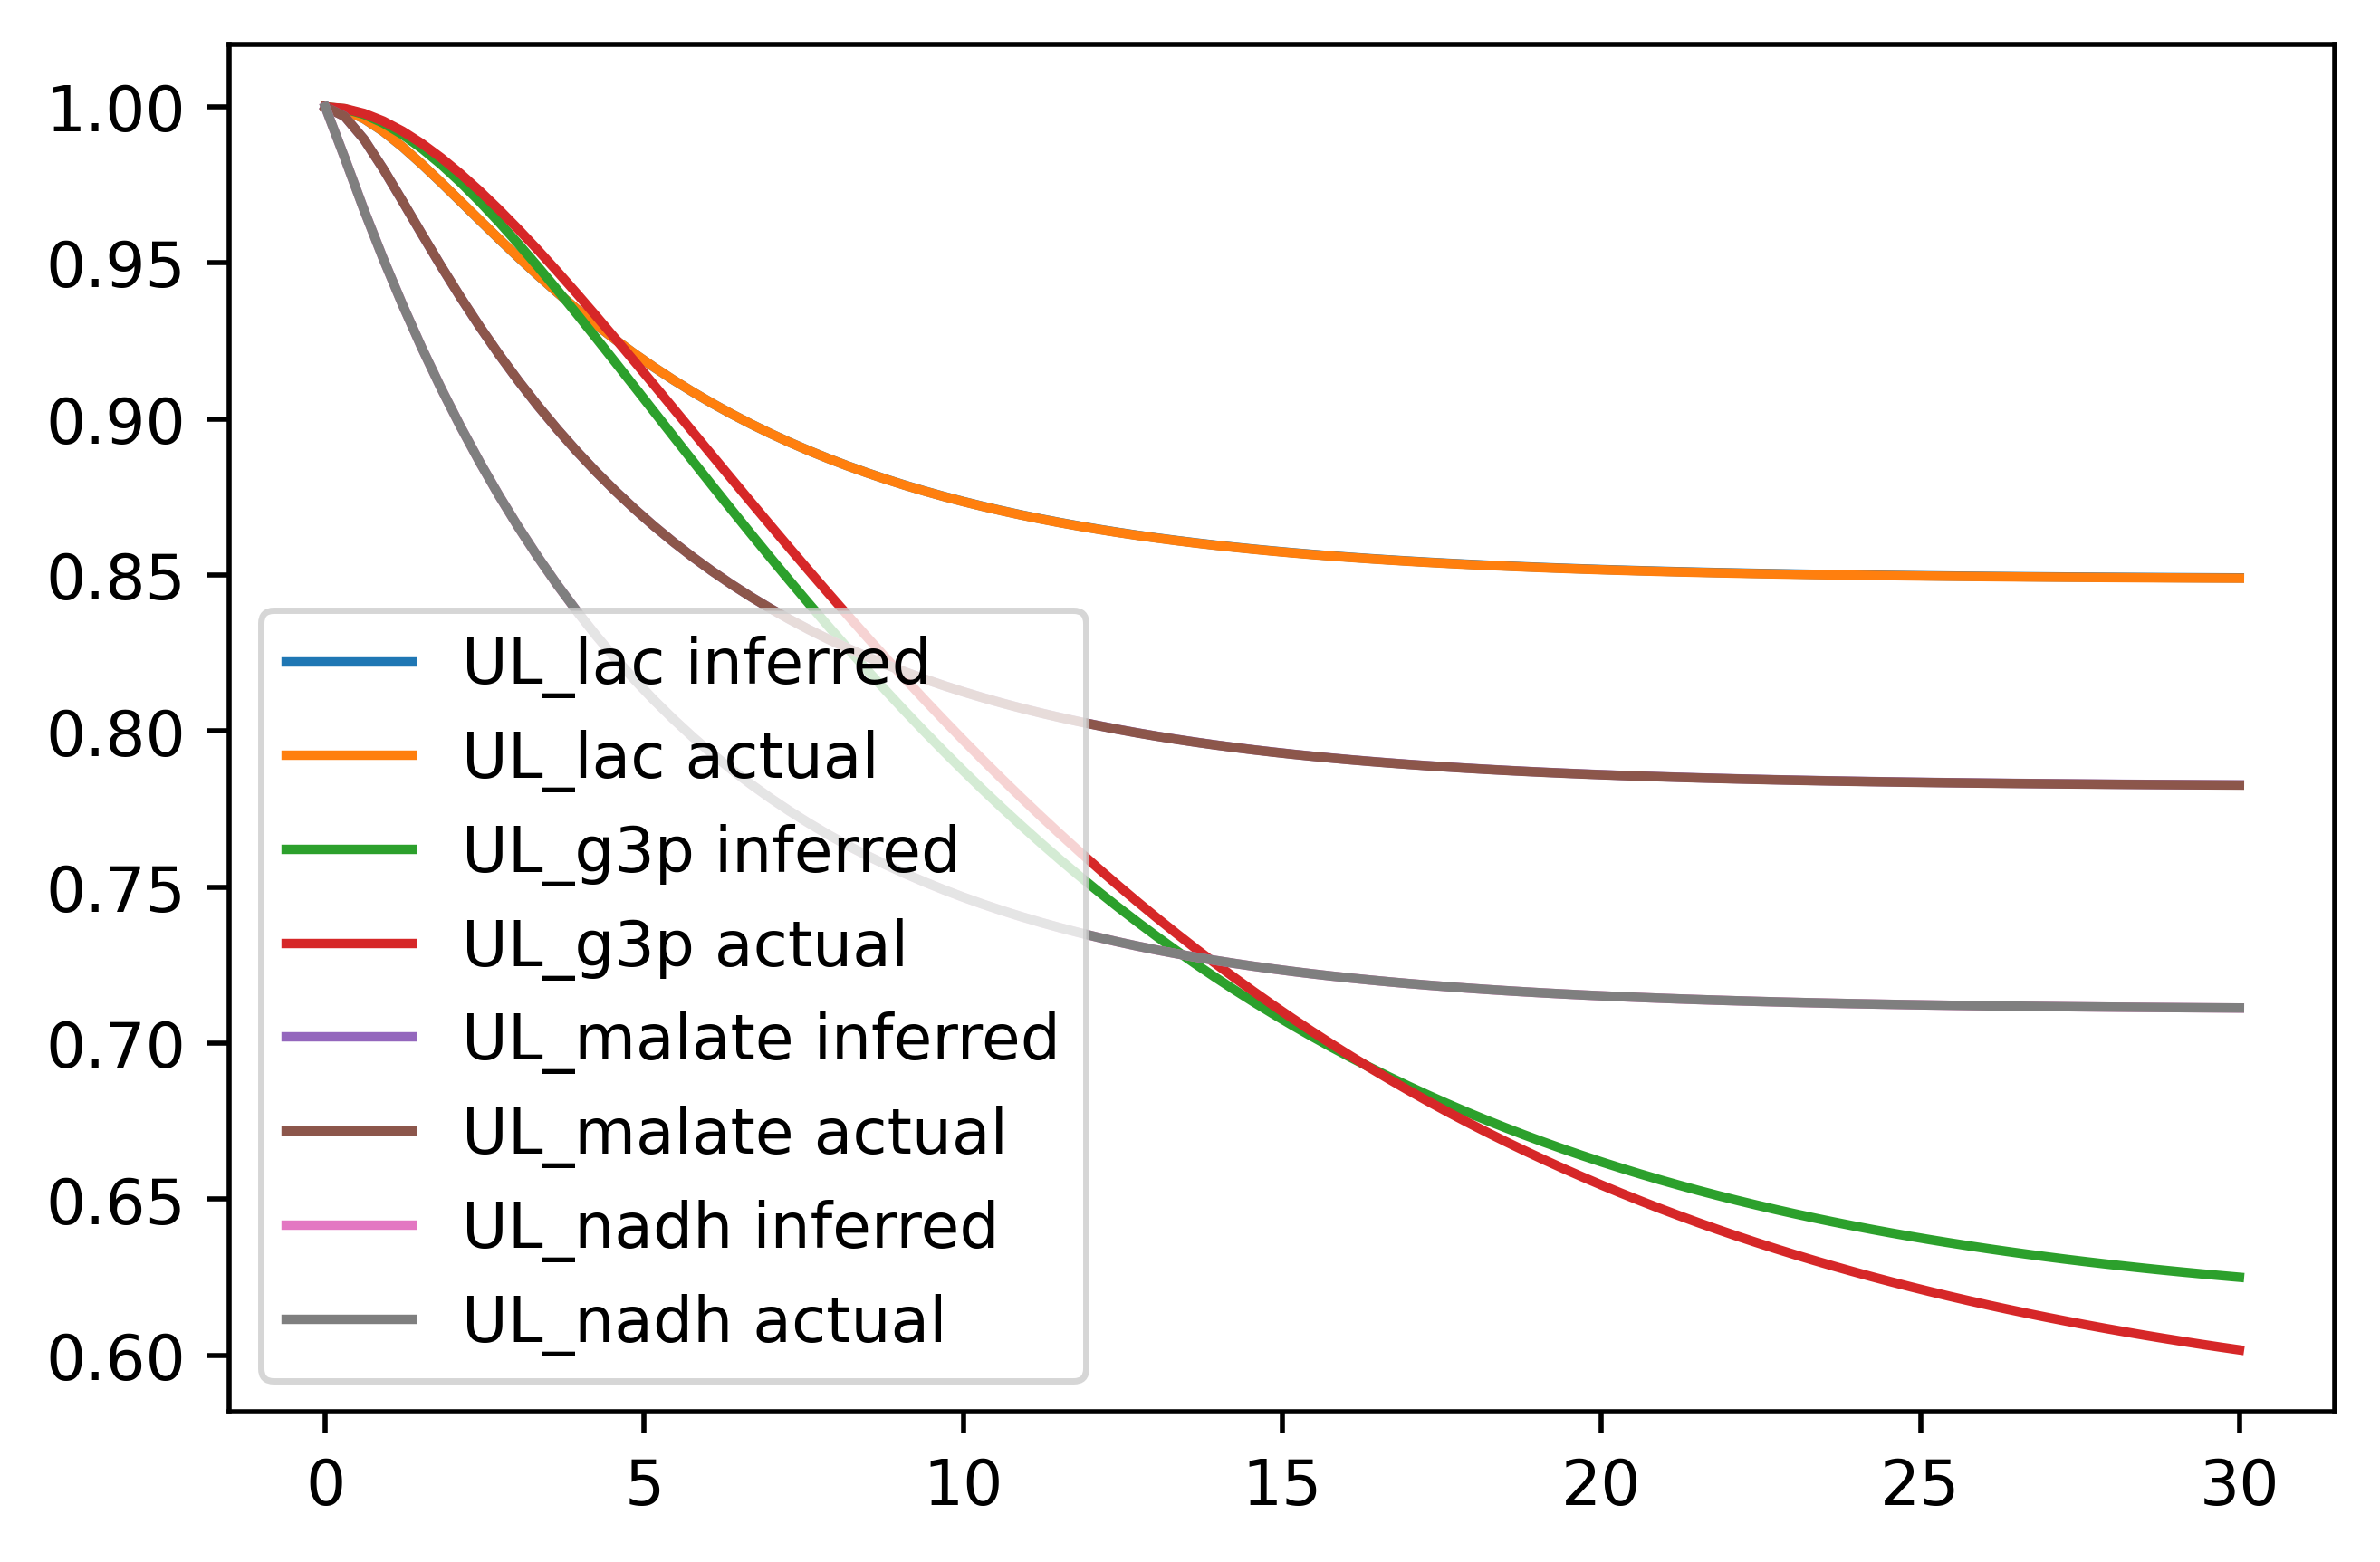

In [8]:
values = integrateLabelingModel(ts, fluxes_inferred,conc,dhap_params,C0s_inferred,vhvds,initialState)
inferred = pd.DataFrame(data=values,columns=["UL_lac","UL_g3p","UL_malate","UL_nadh"])
for col in ["UL_lac","UL_g3p","UL_malate","UL_nadh"]:
    plt.plot(ts,inferred[col],label=col + " inferred")
    plt.plot(ts,data[col],label=col+" actual")
plt.legend()


In [14]:
if __name__ == '__main__':
    true = []
    pred = []
    err = []
    args = [[ts,numBestFitIters] for _ in range(numSims)]
    result = startConcurrentTask(simulateDataAndInferFlux,args,numCores,"running simulations",len(args))
    for fluxes,(inferred_fluxes,_,_,conc,errs) in result:
        true.append(fluxes)
        pred.append(inferred_fluxes)
        err.append(errs)
true = np.array(true)
pred = np.array(pred)
err = np.array(err)

running simulations |██████████████████████████████████████████████████| 100.0% 


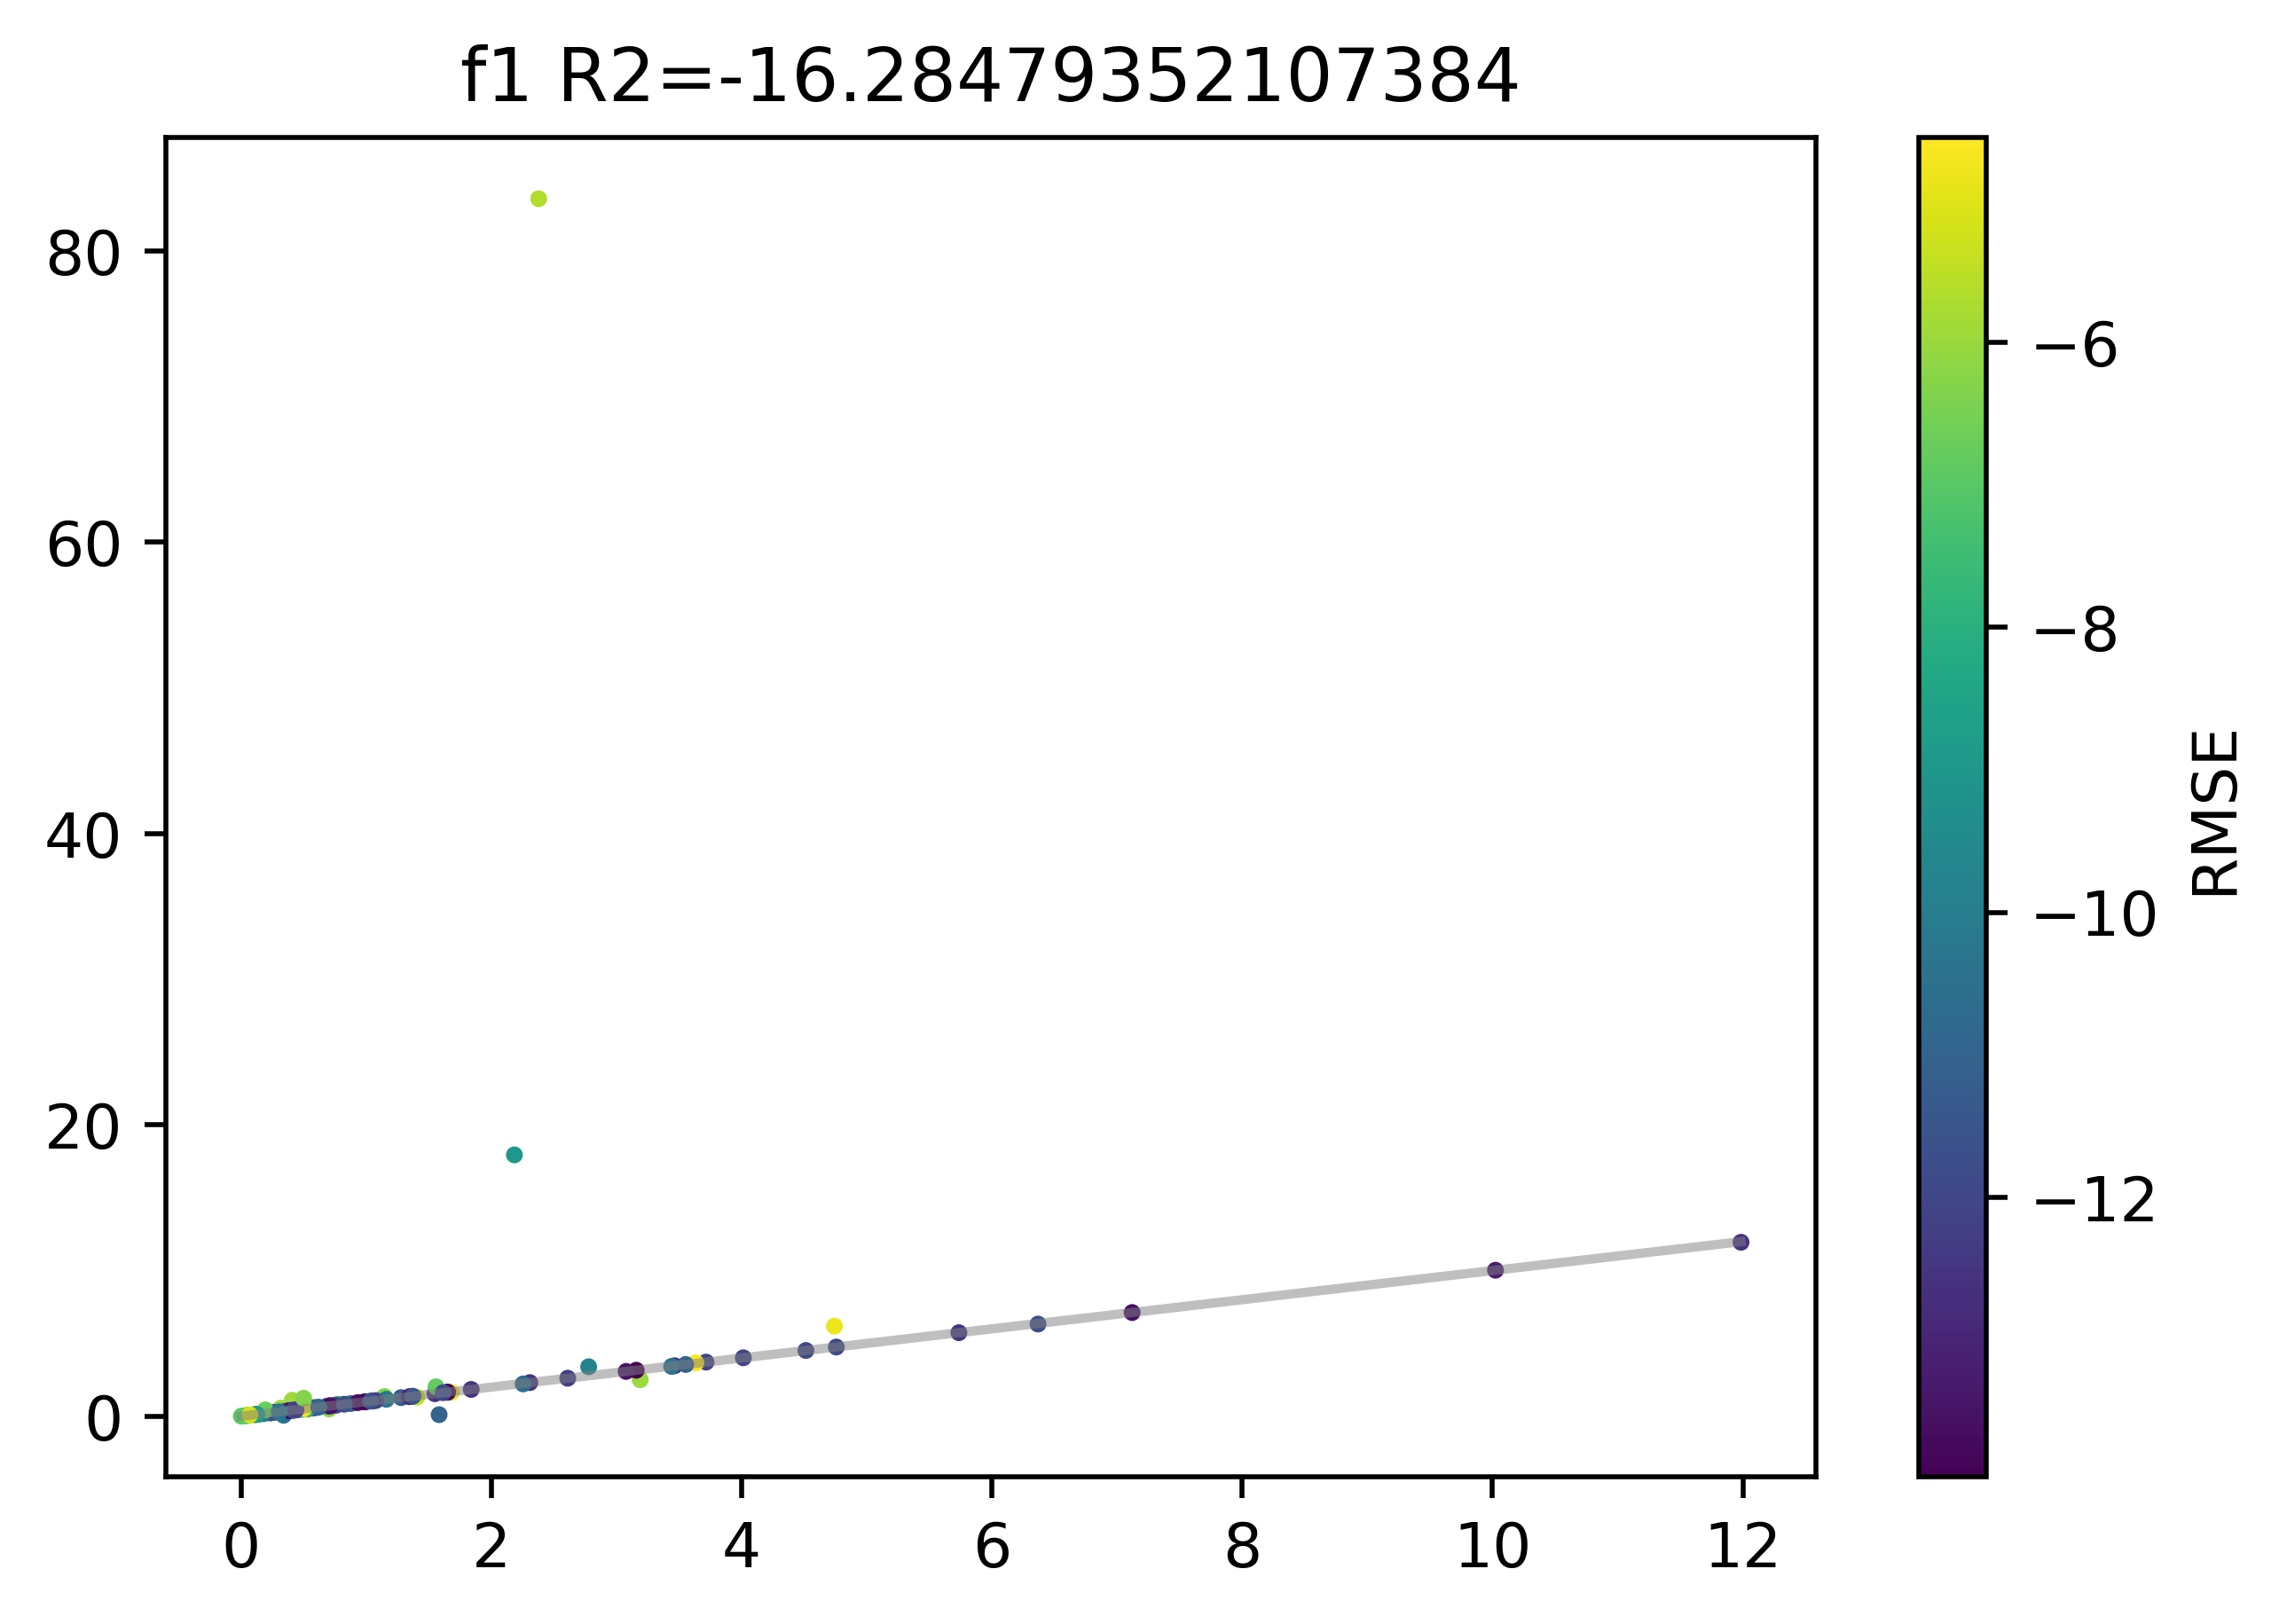

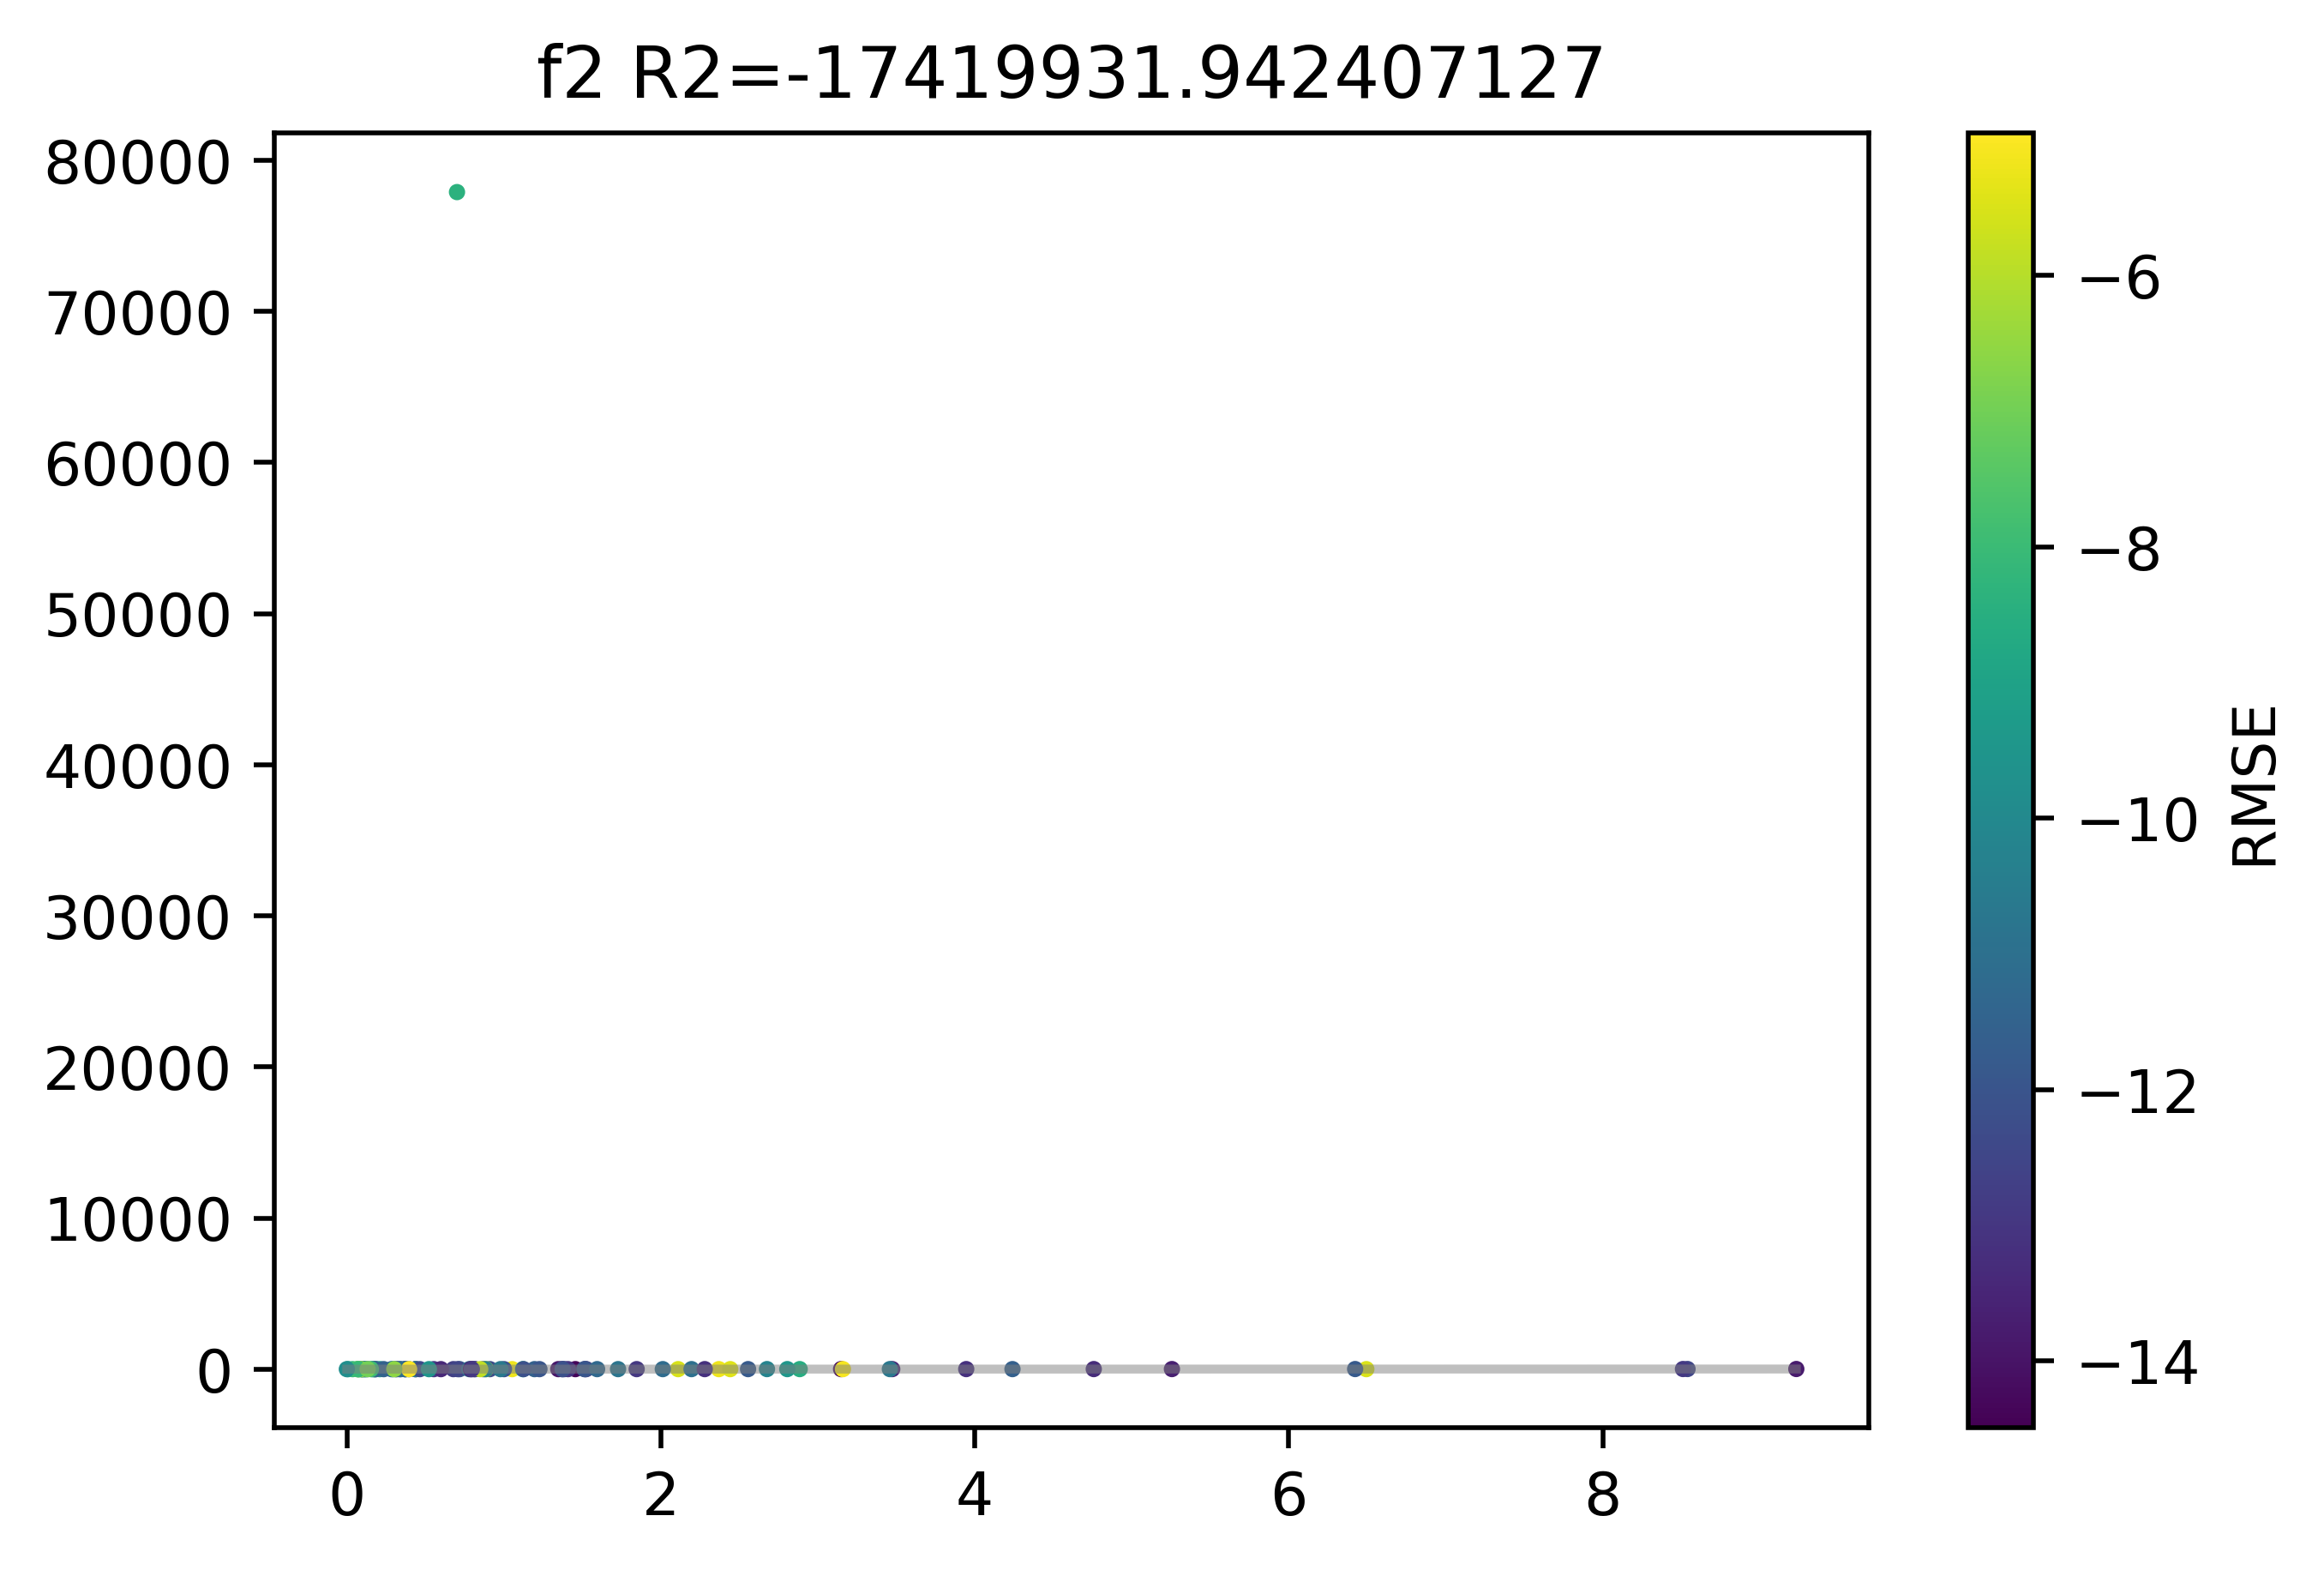

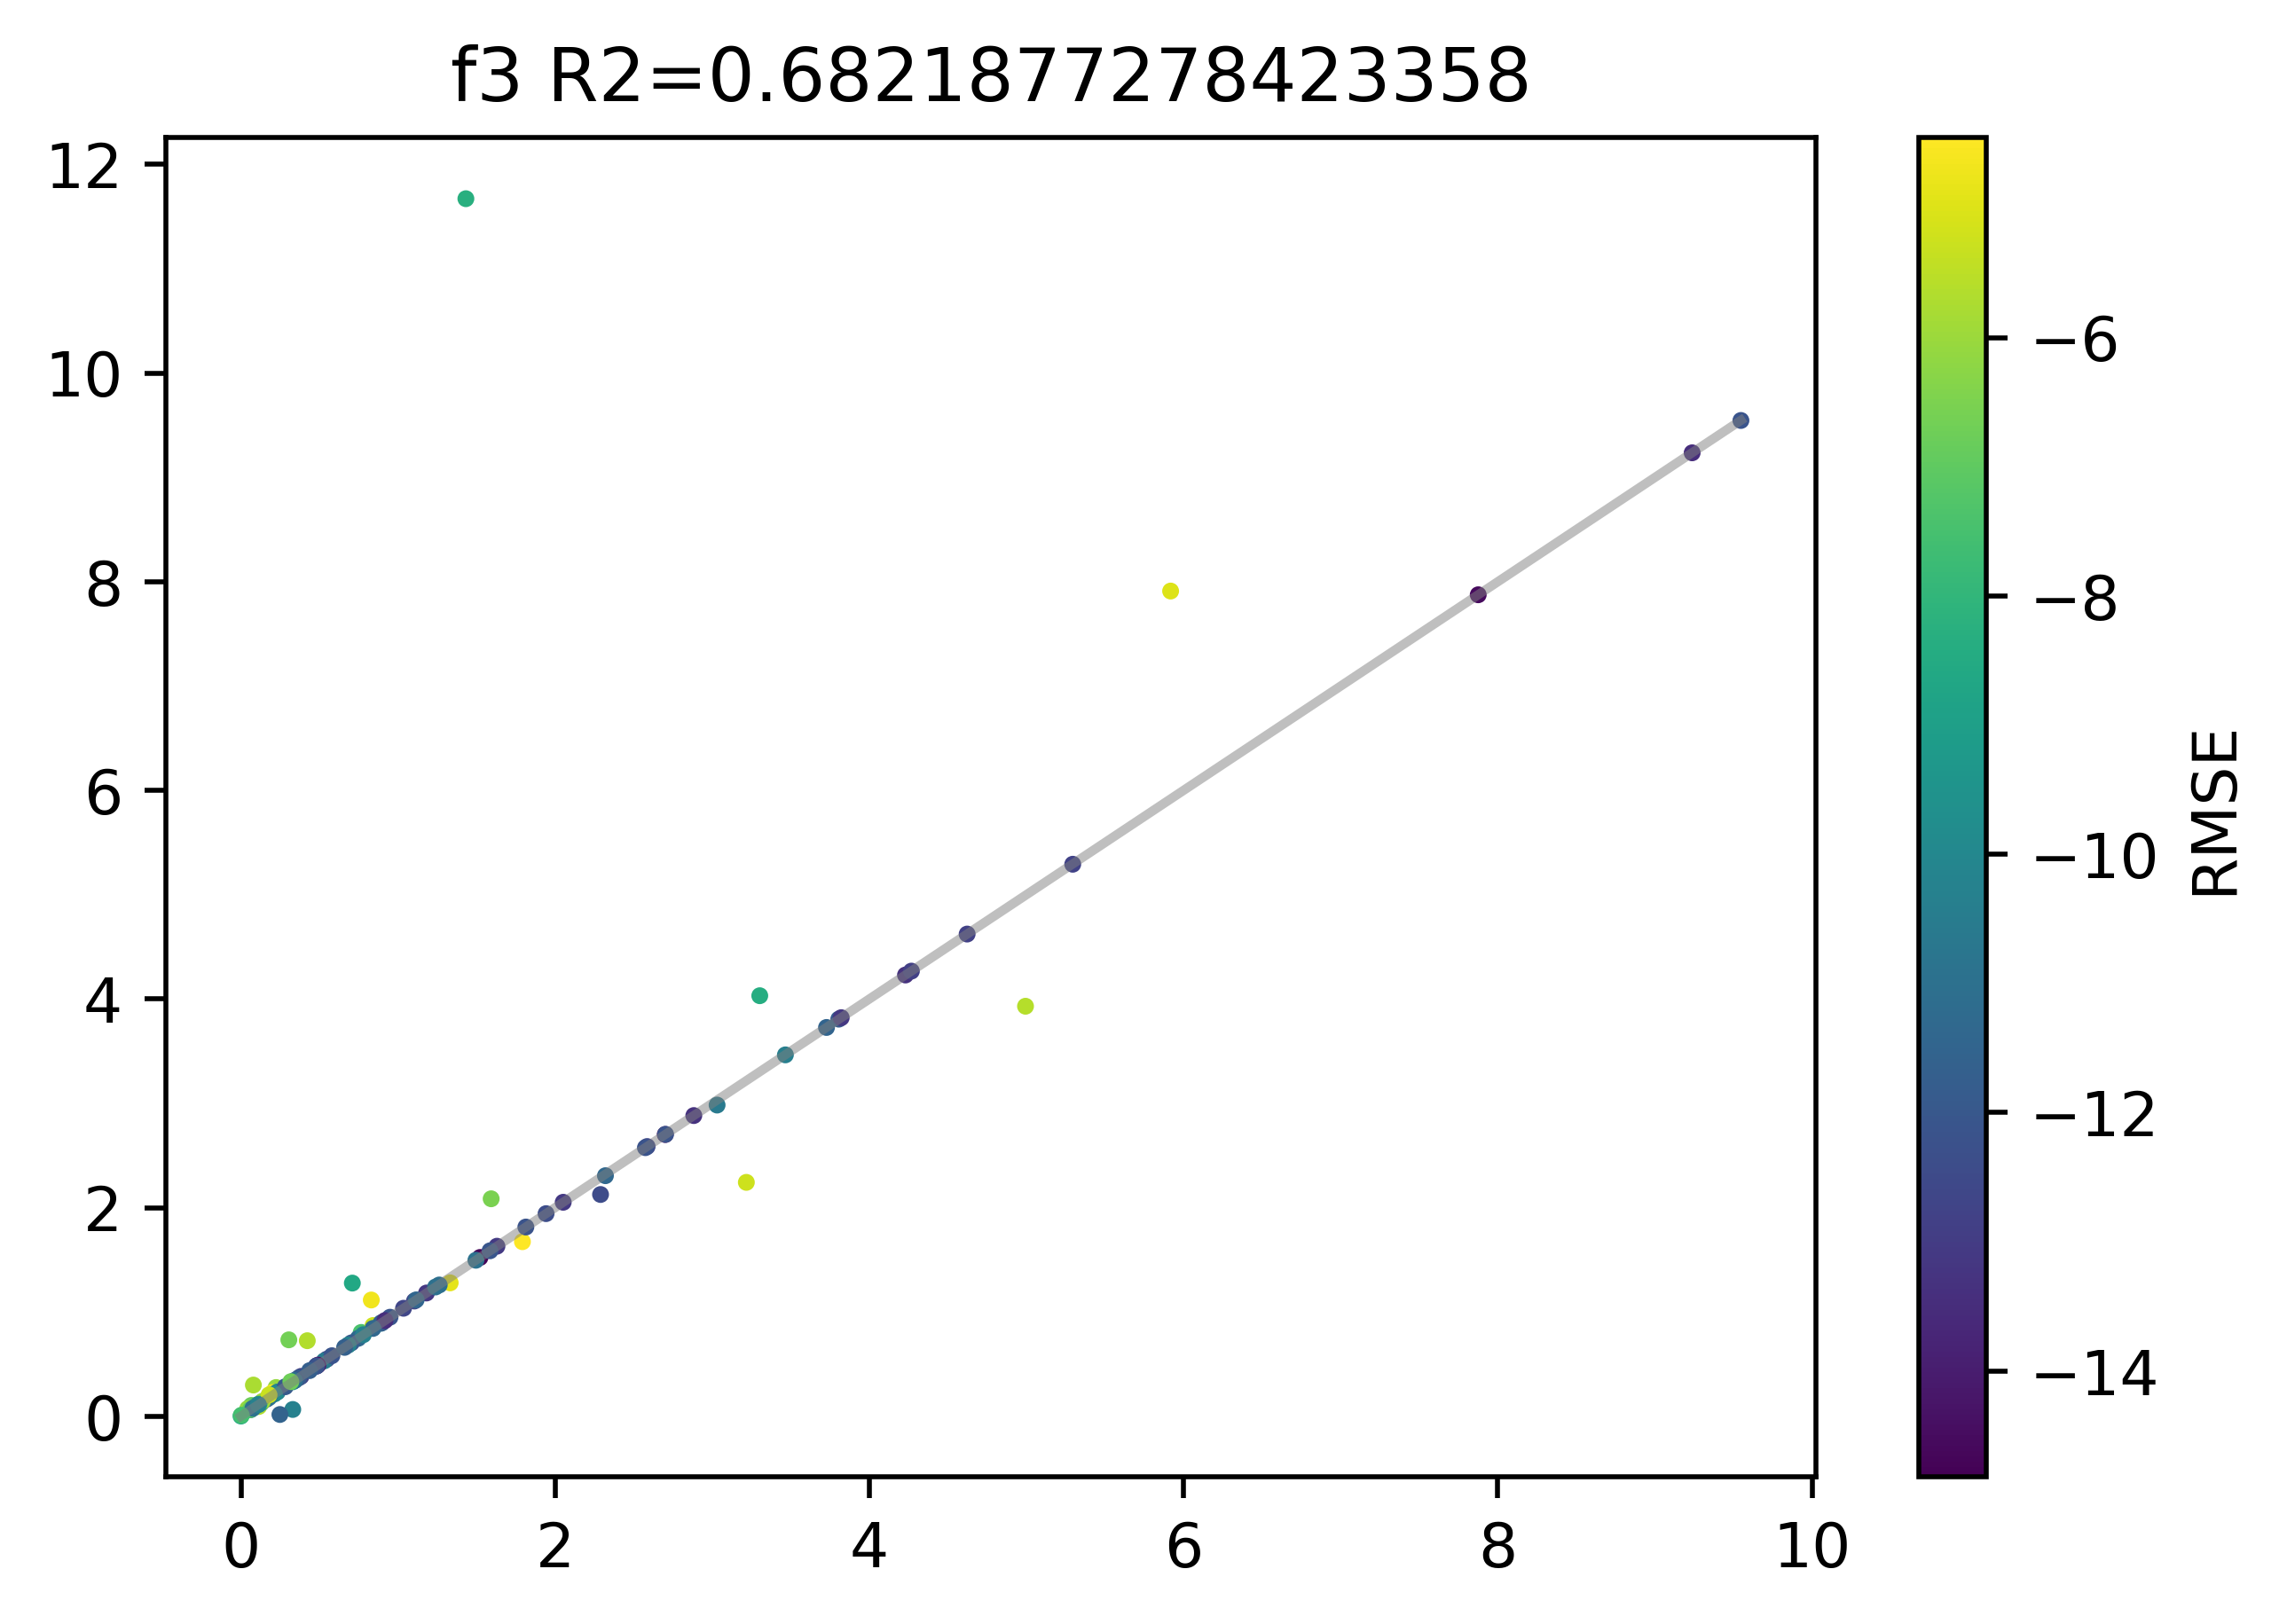

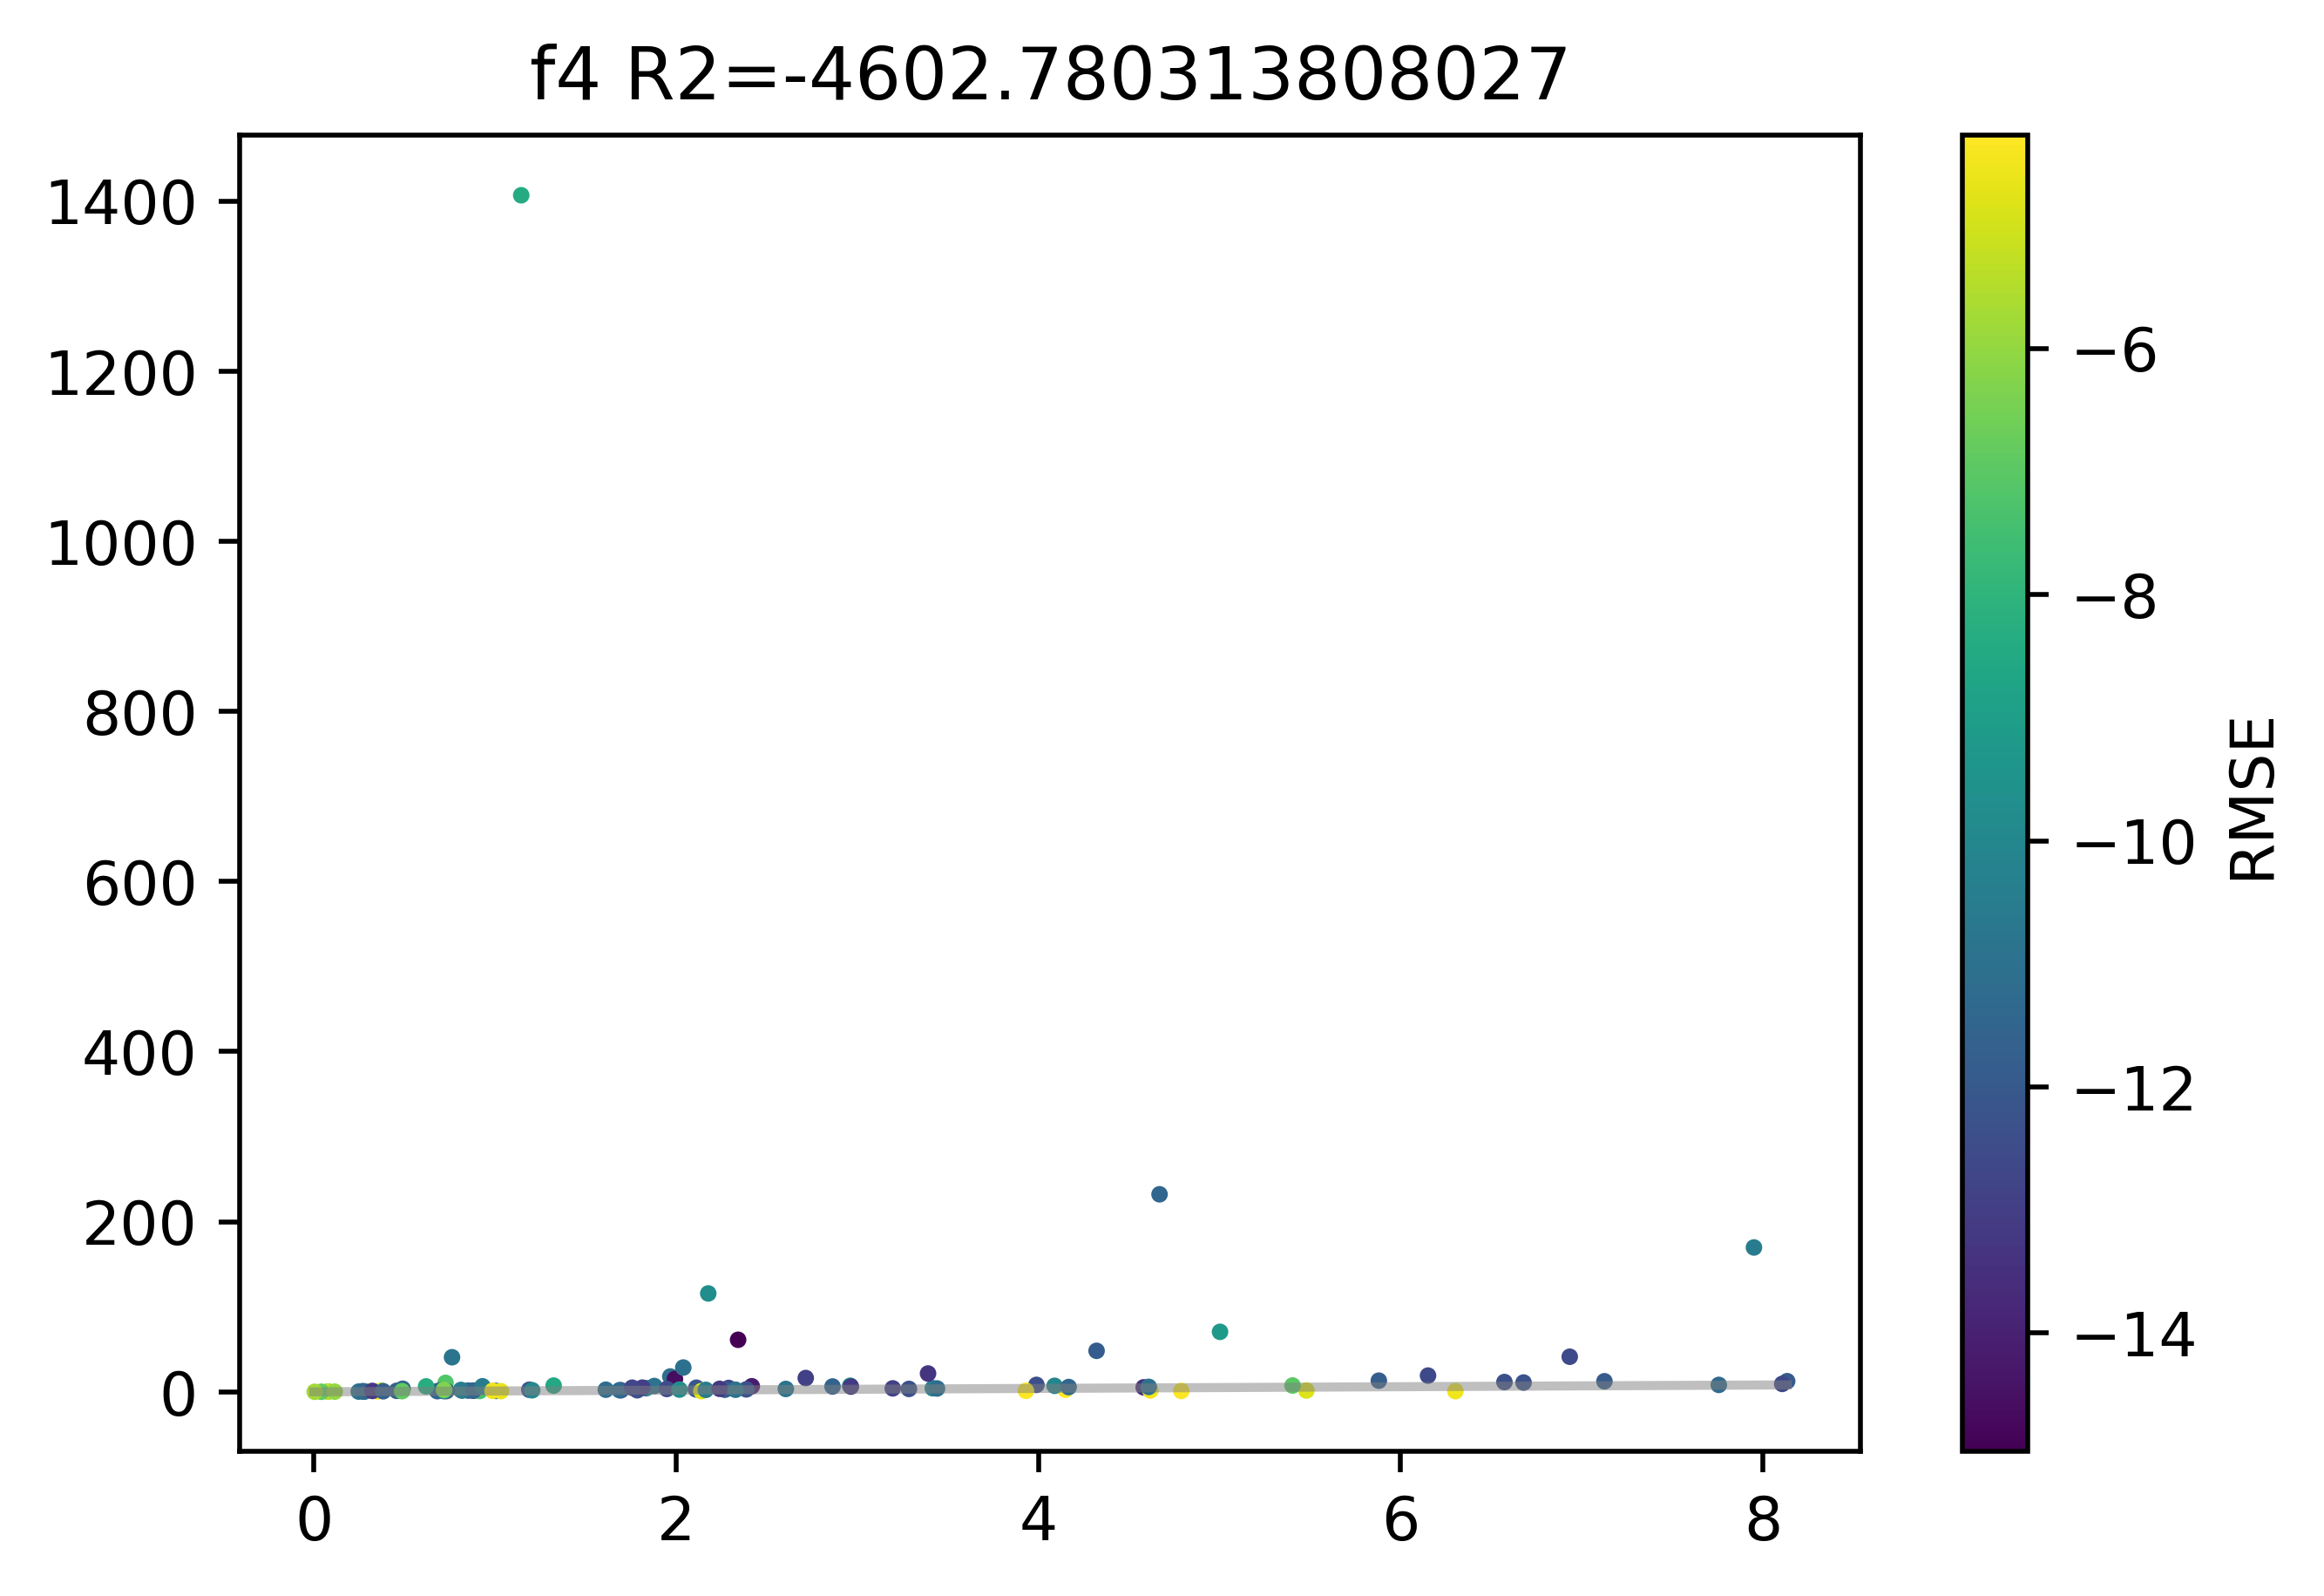

In [15]:
for x in range(pred.shape[1]):
    plt.figure()
    plt.scatter(true[:,x],pred[:,x],s=3,c=np.log10(err[:,x]))
    plt.plot([0,max(true[:,x])],[0,max(true[:,x])],color="grey",alpha=.5)
    plt.title("f" + str(x+1) + " R2=" + str(r2_score(true[:,x],pred[:,x])))
    plt.colorbar(label="RMSE")

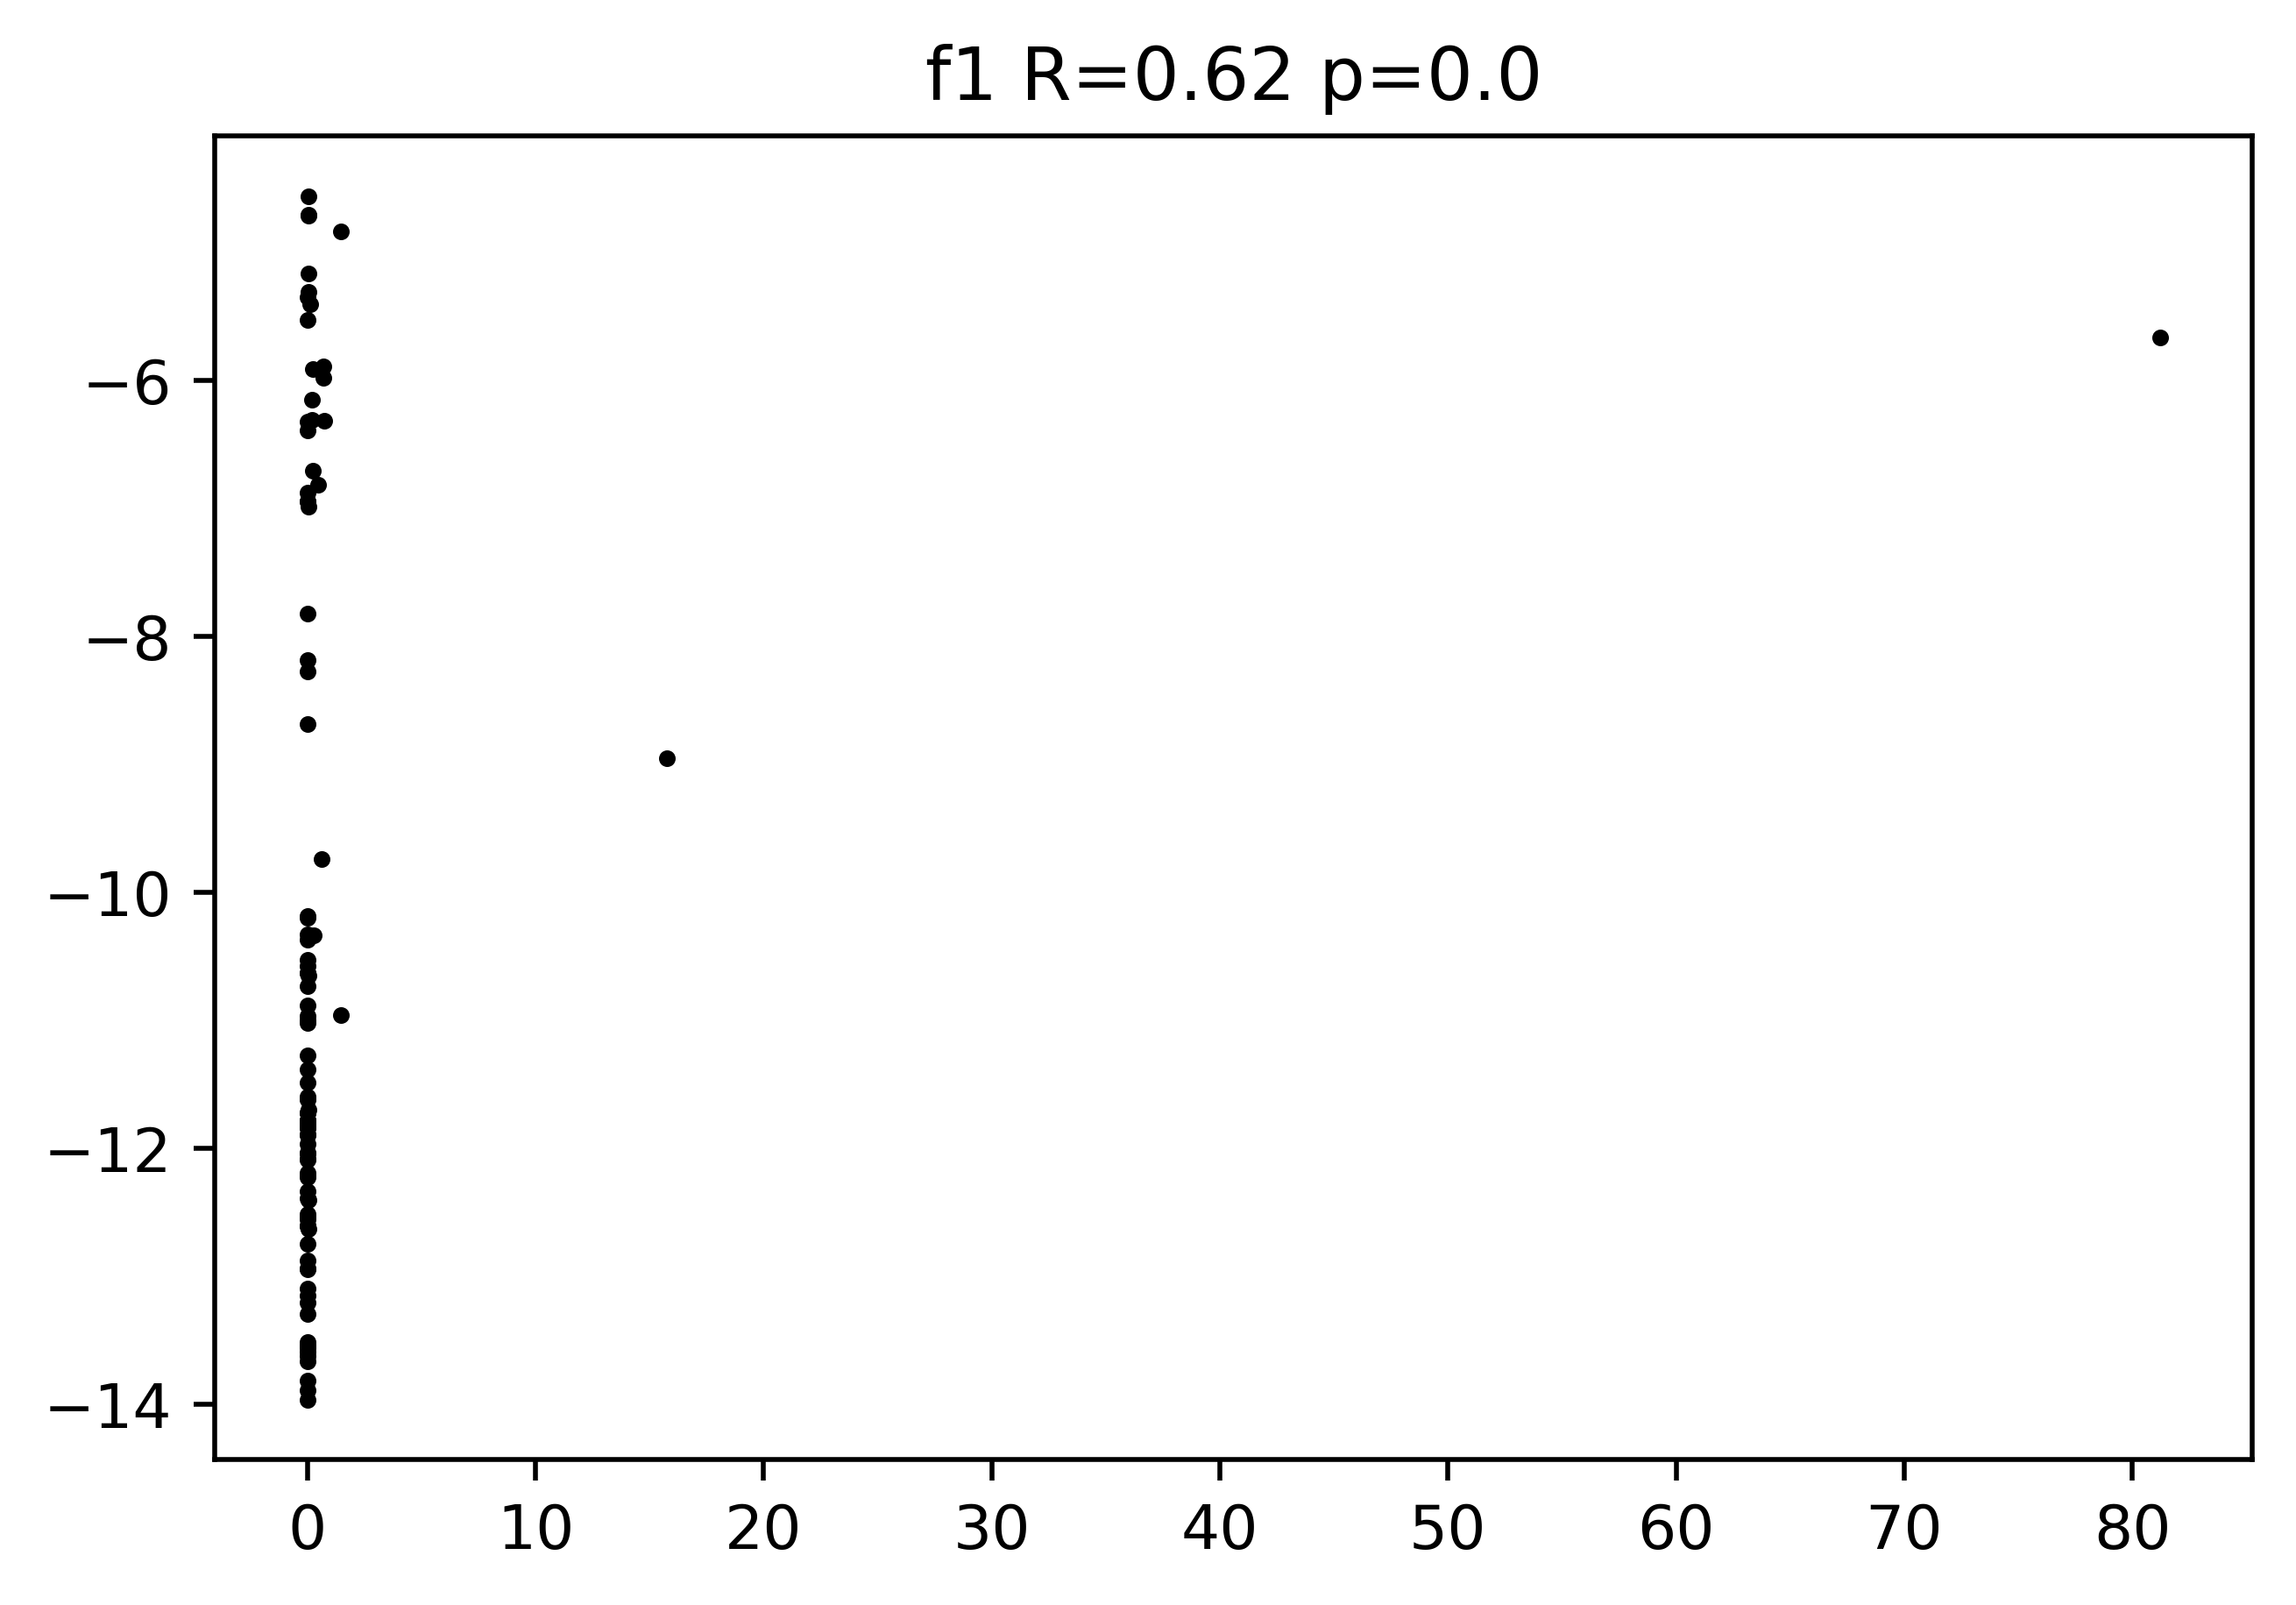

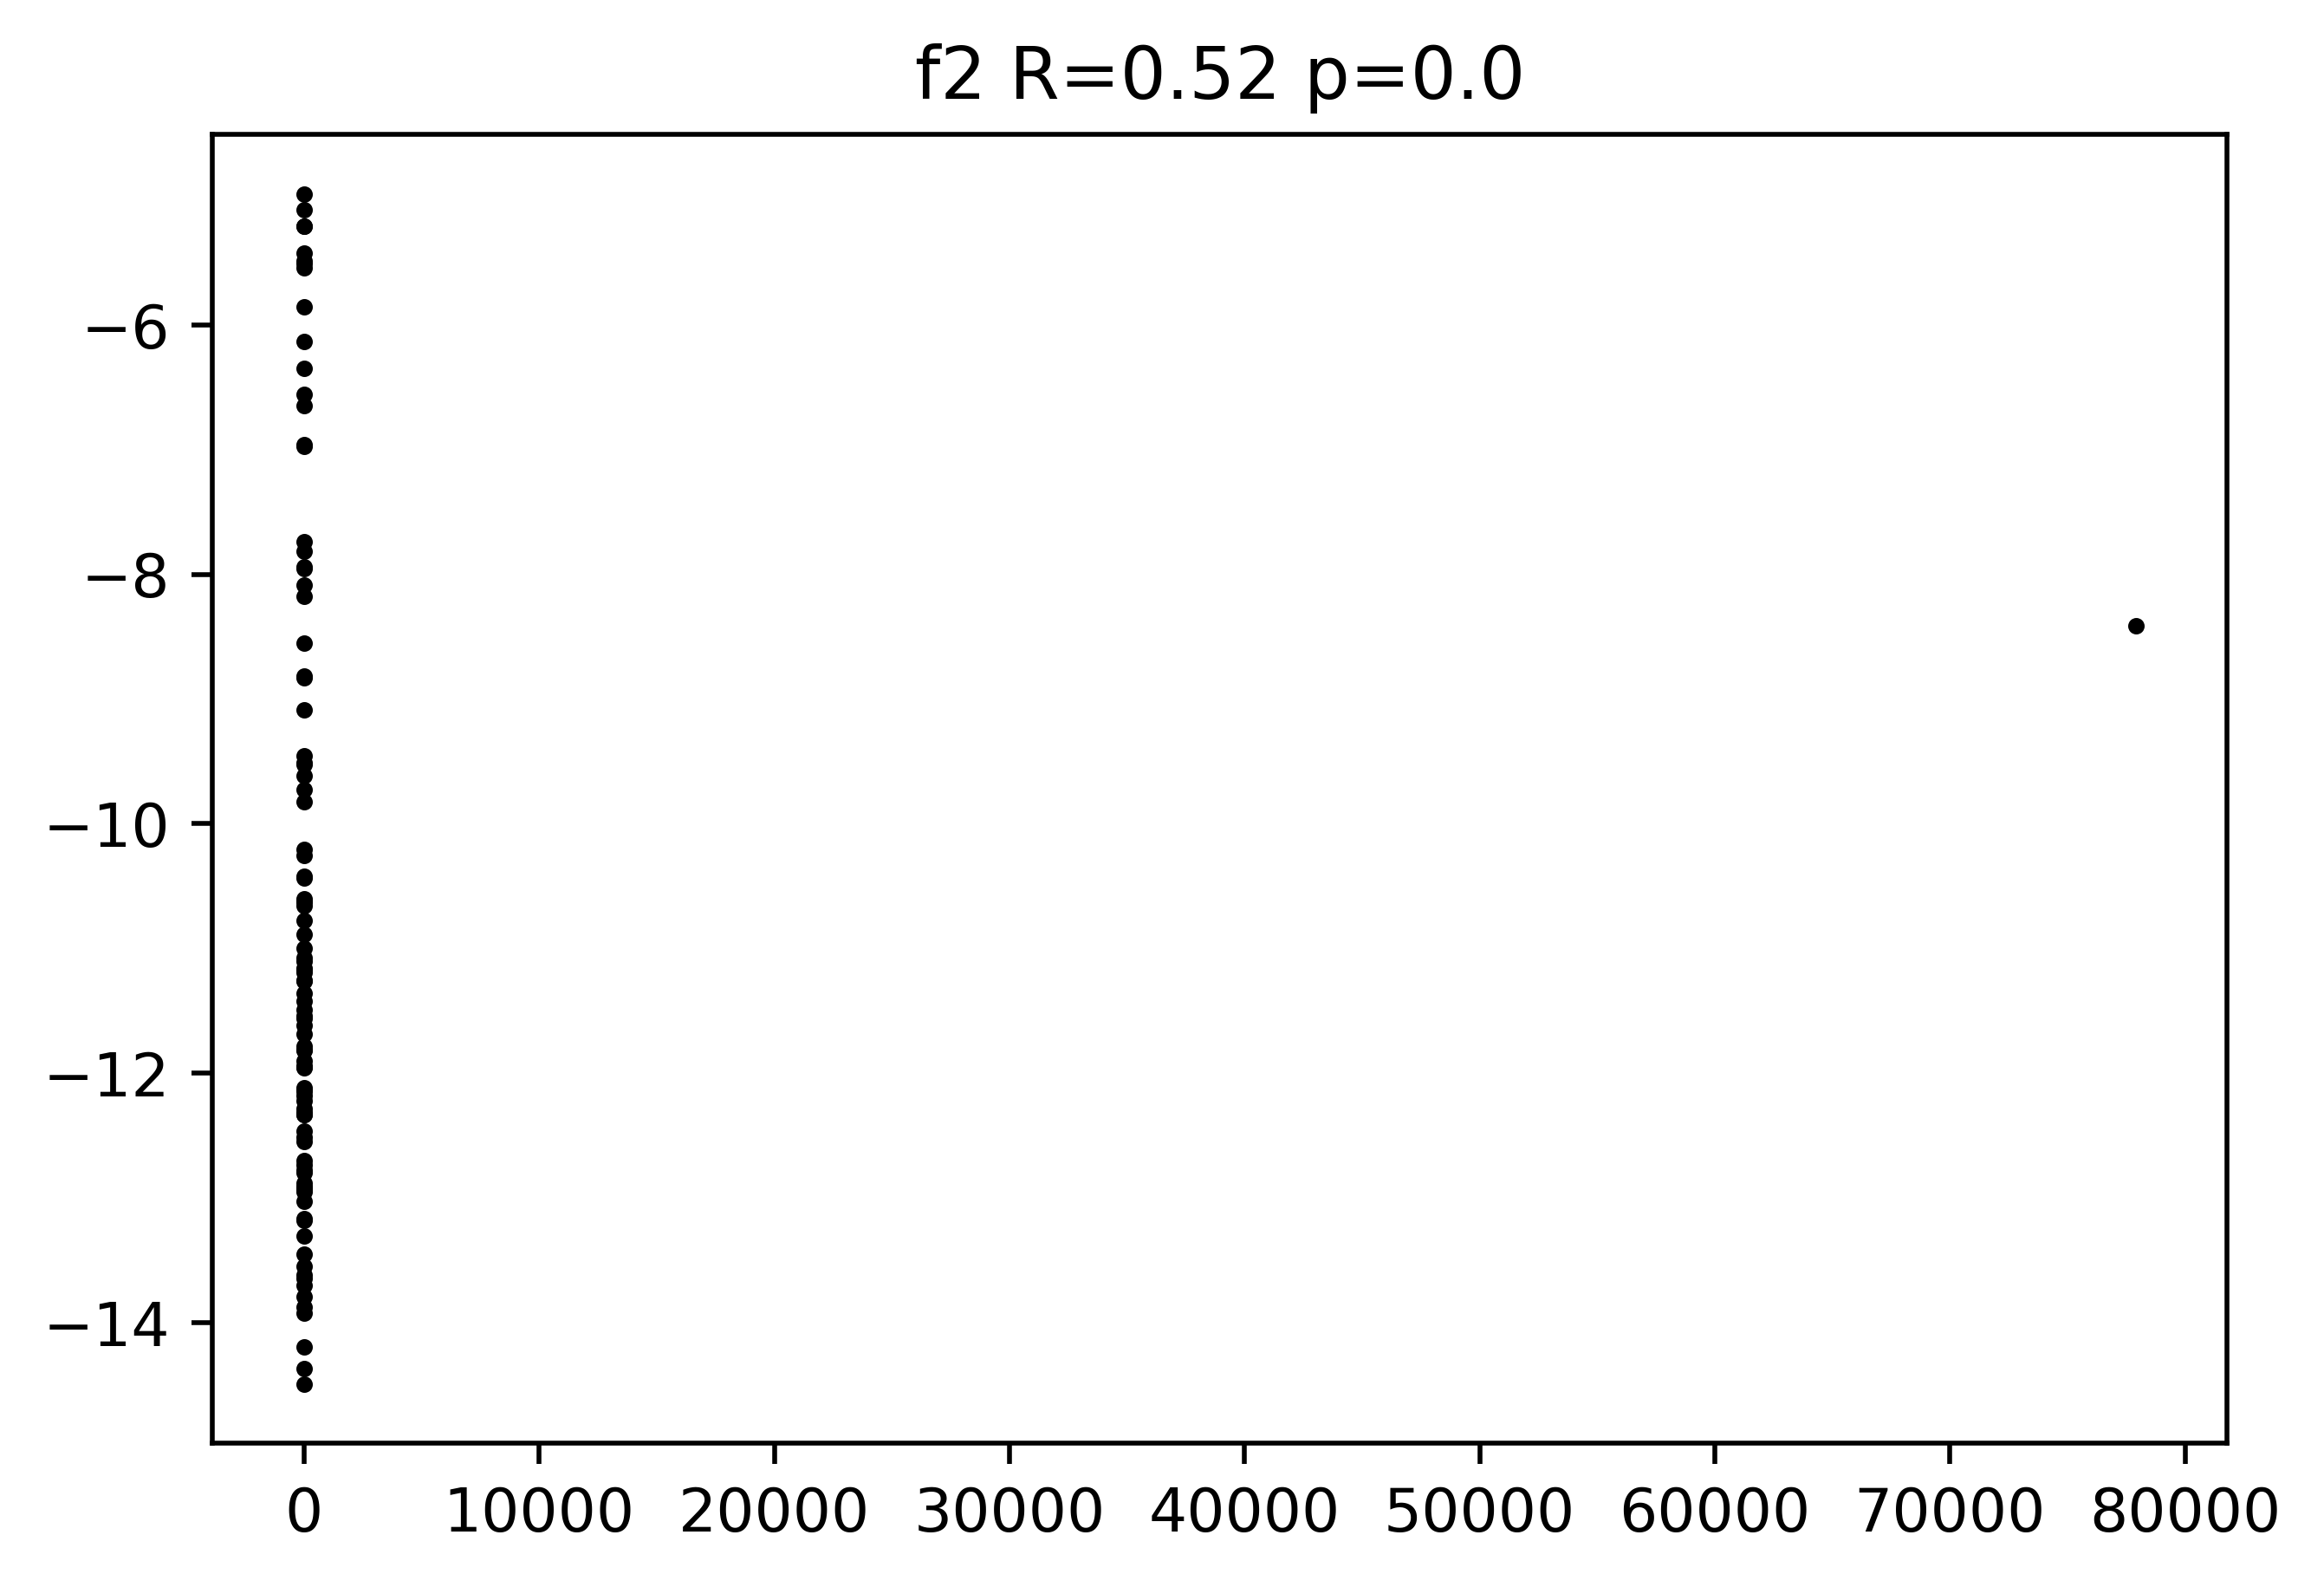

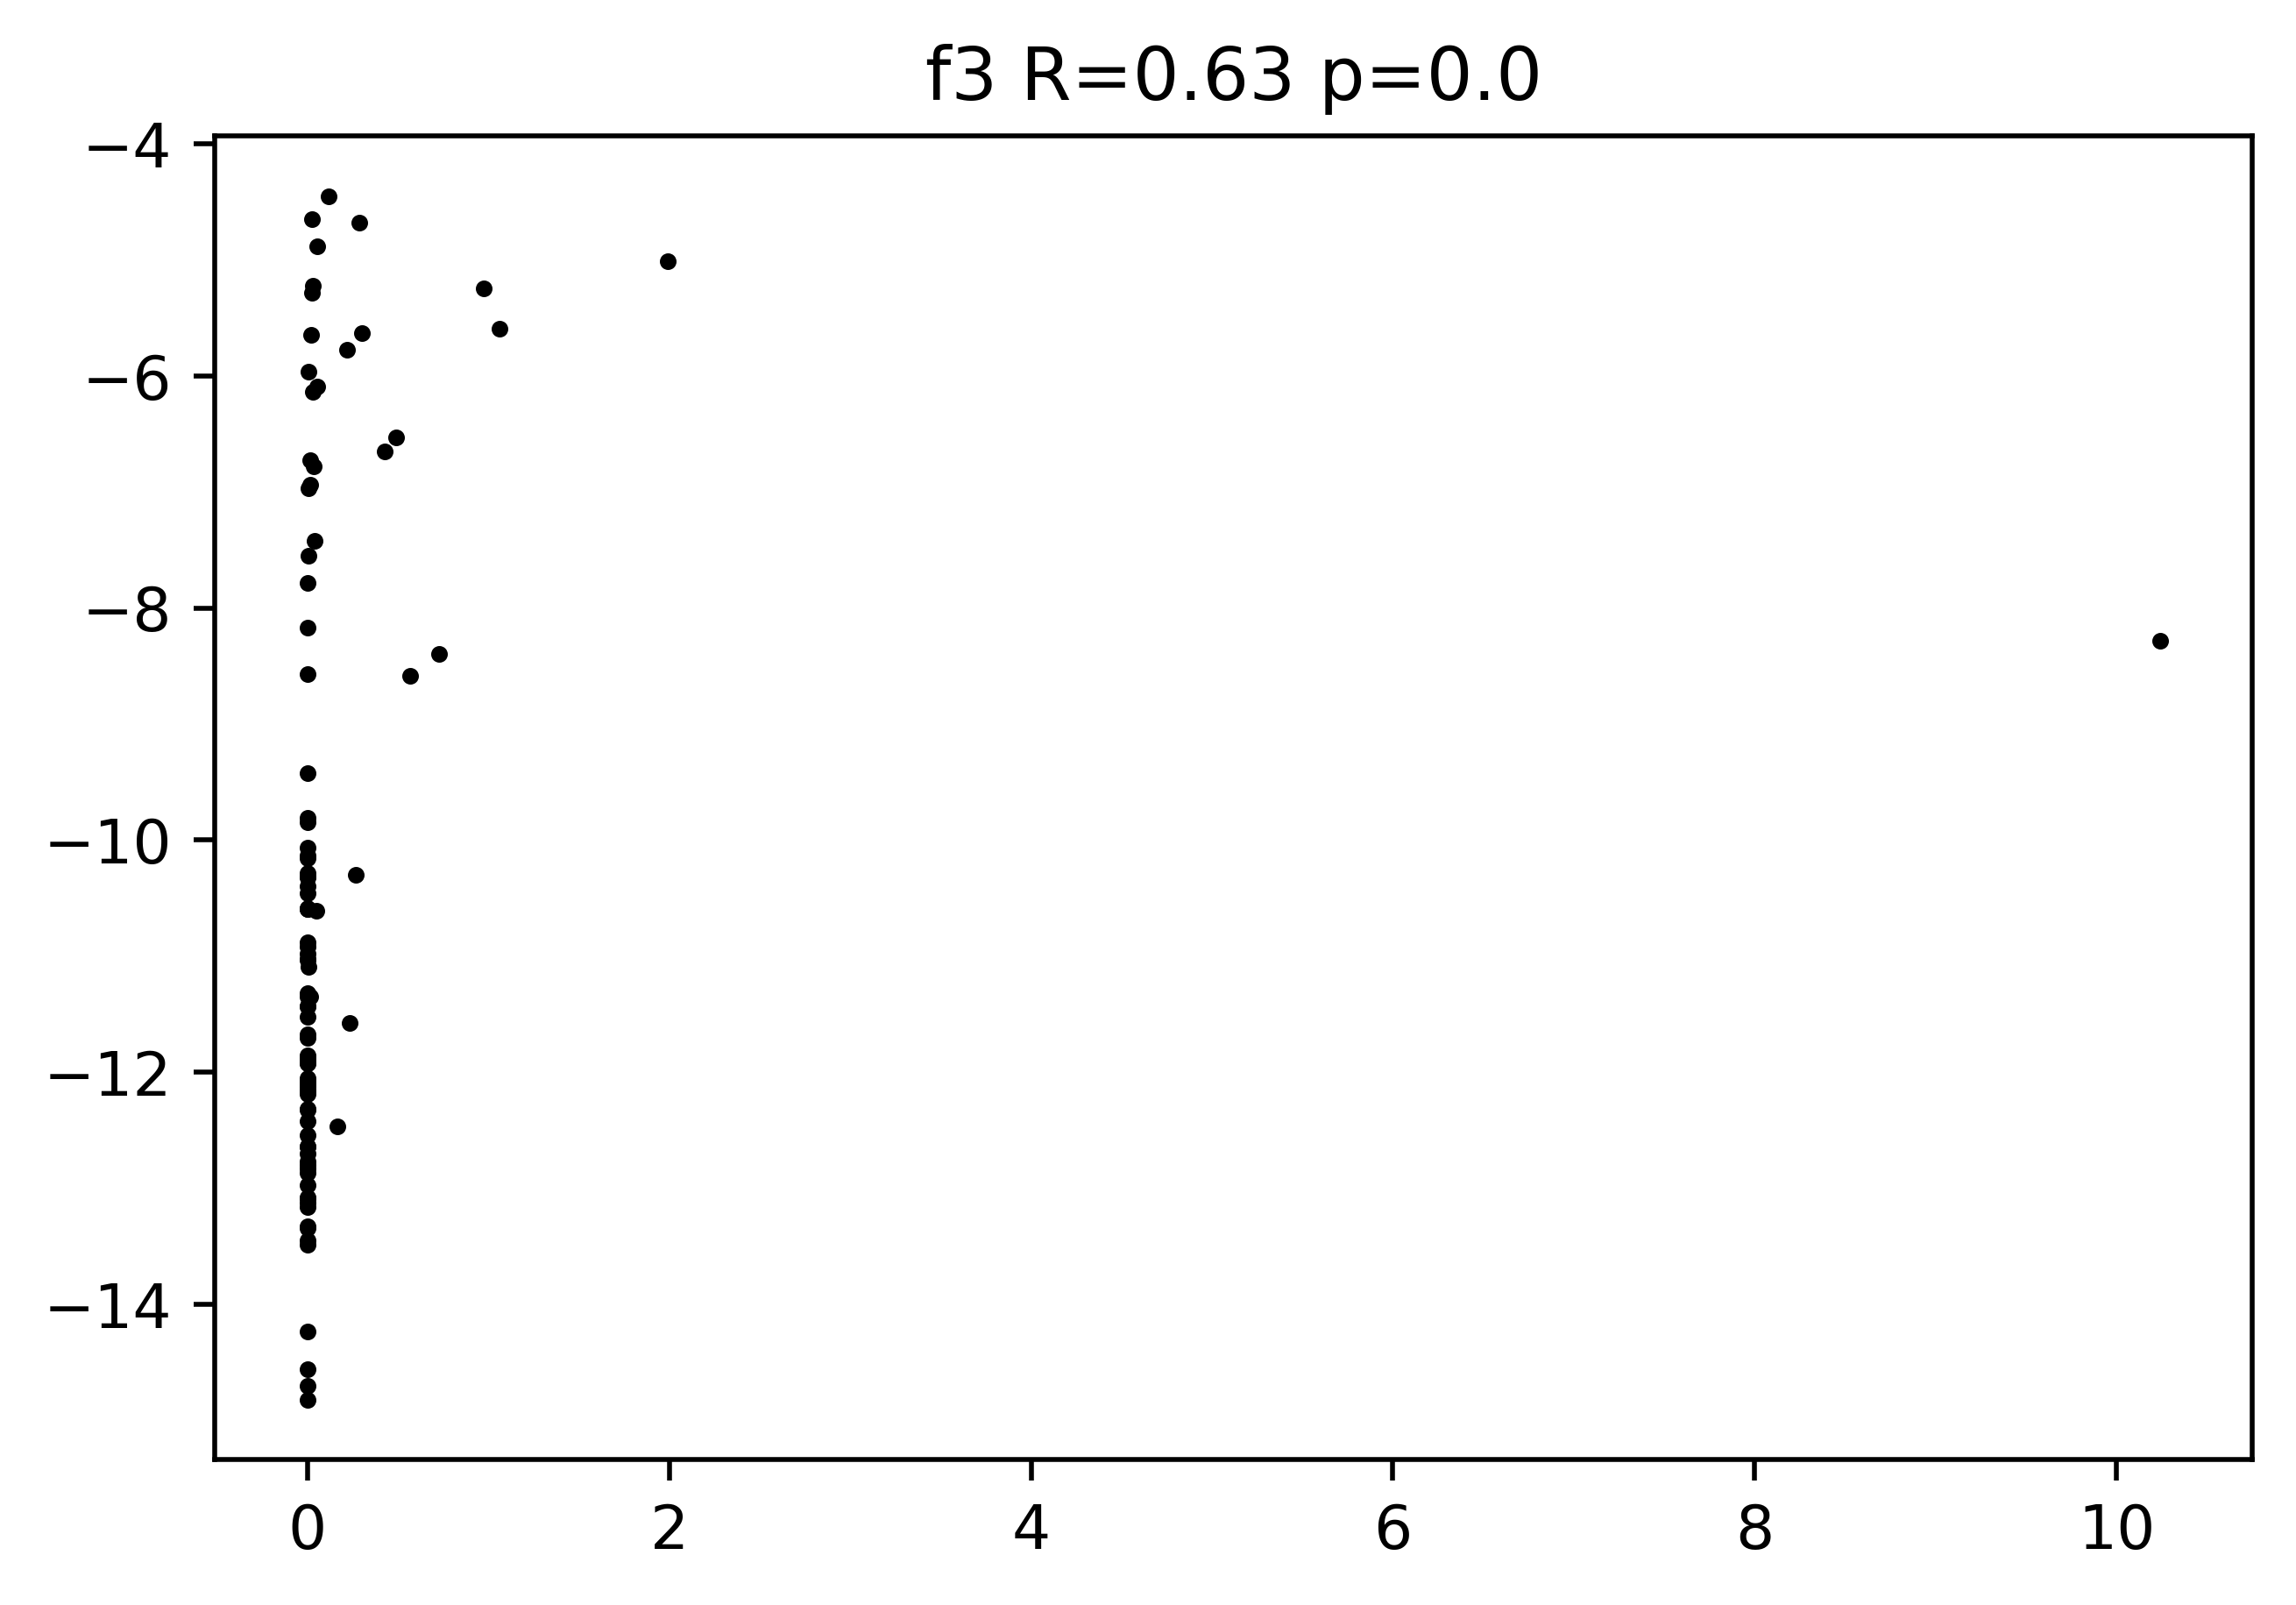

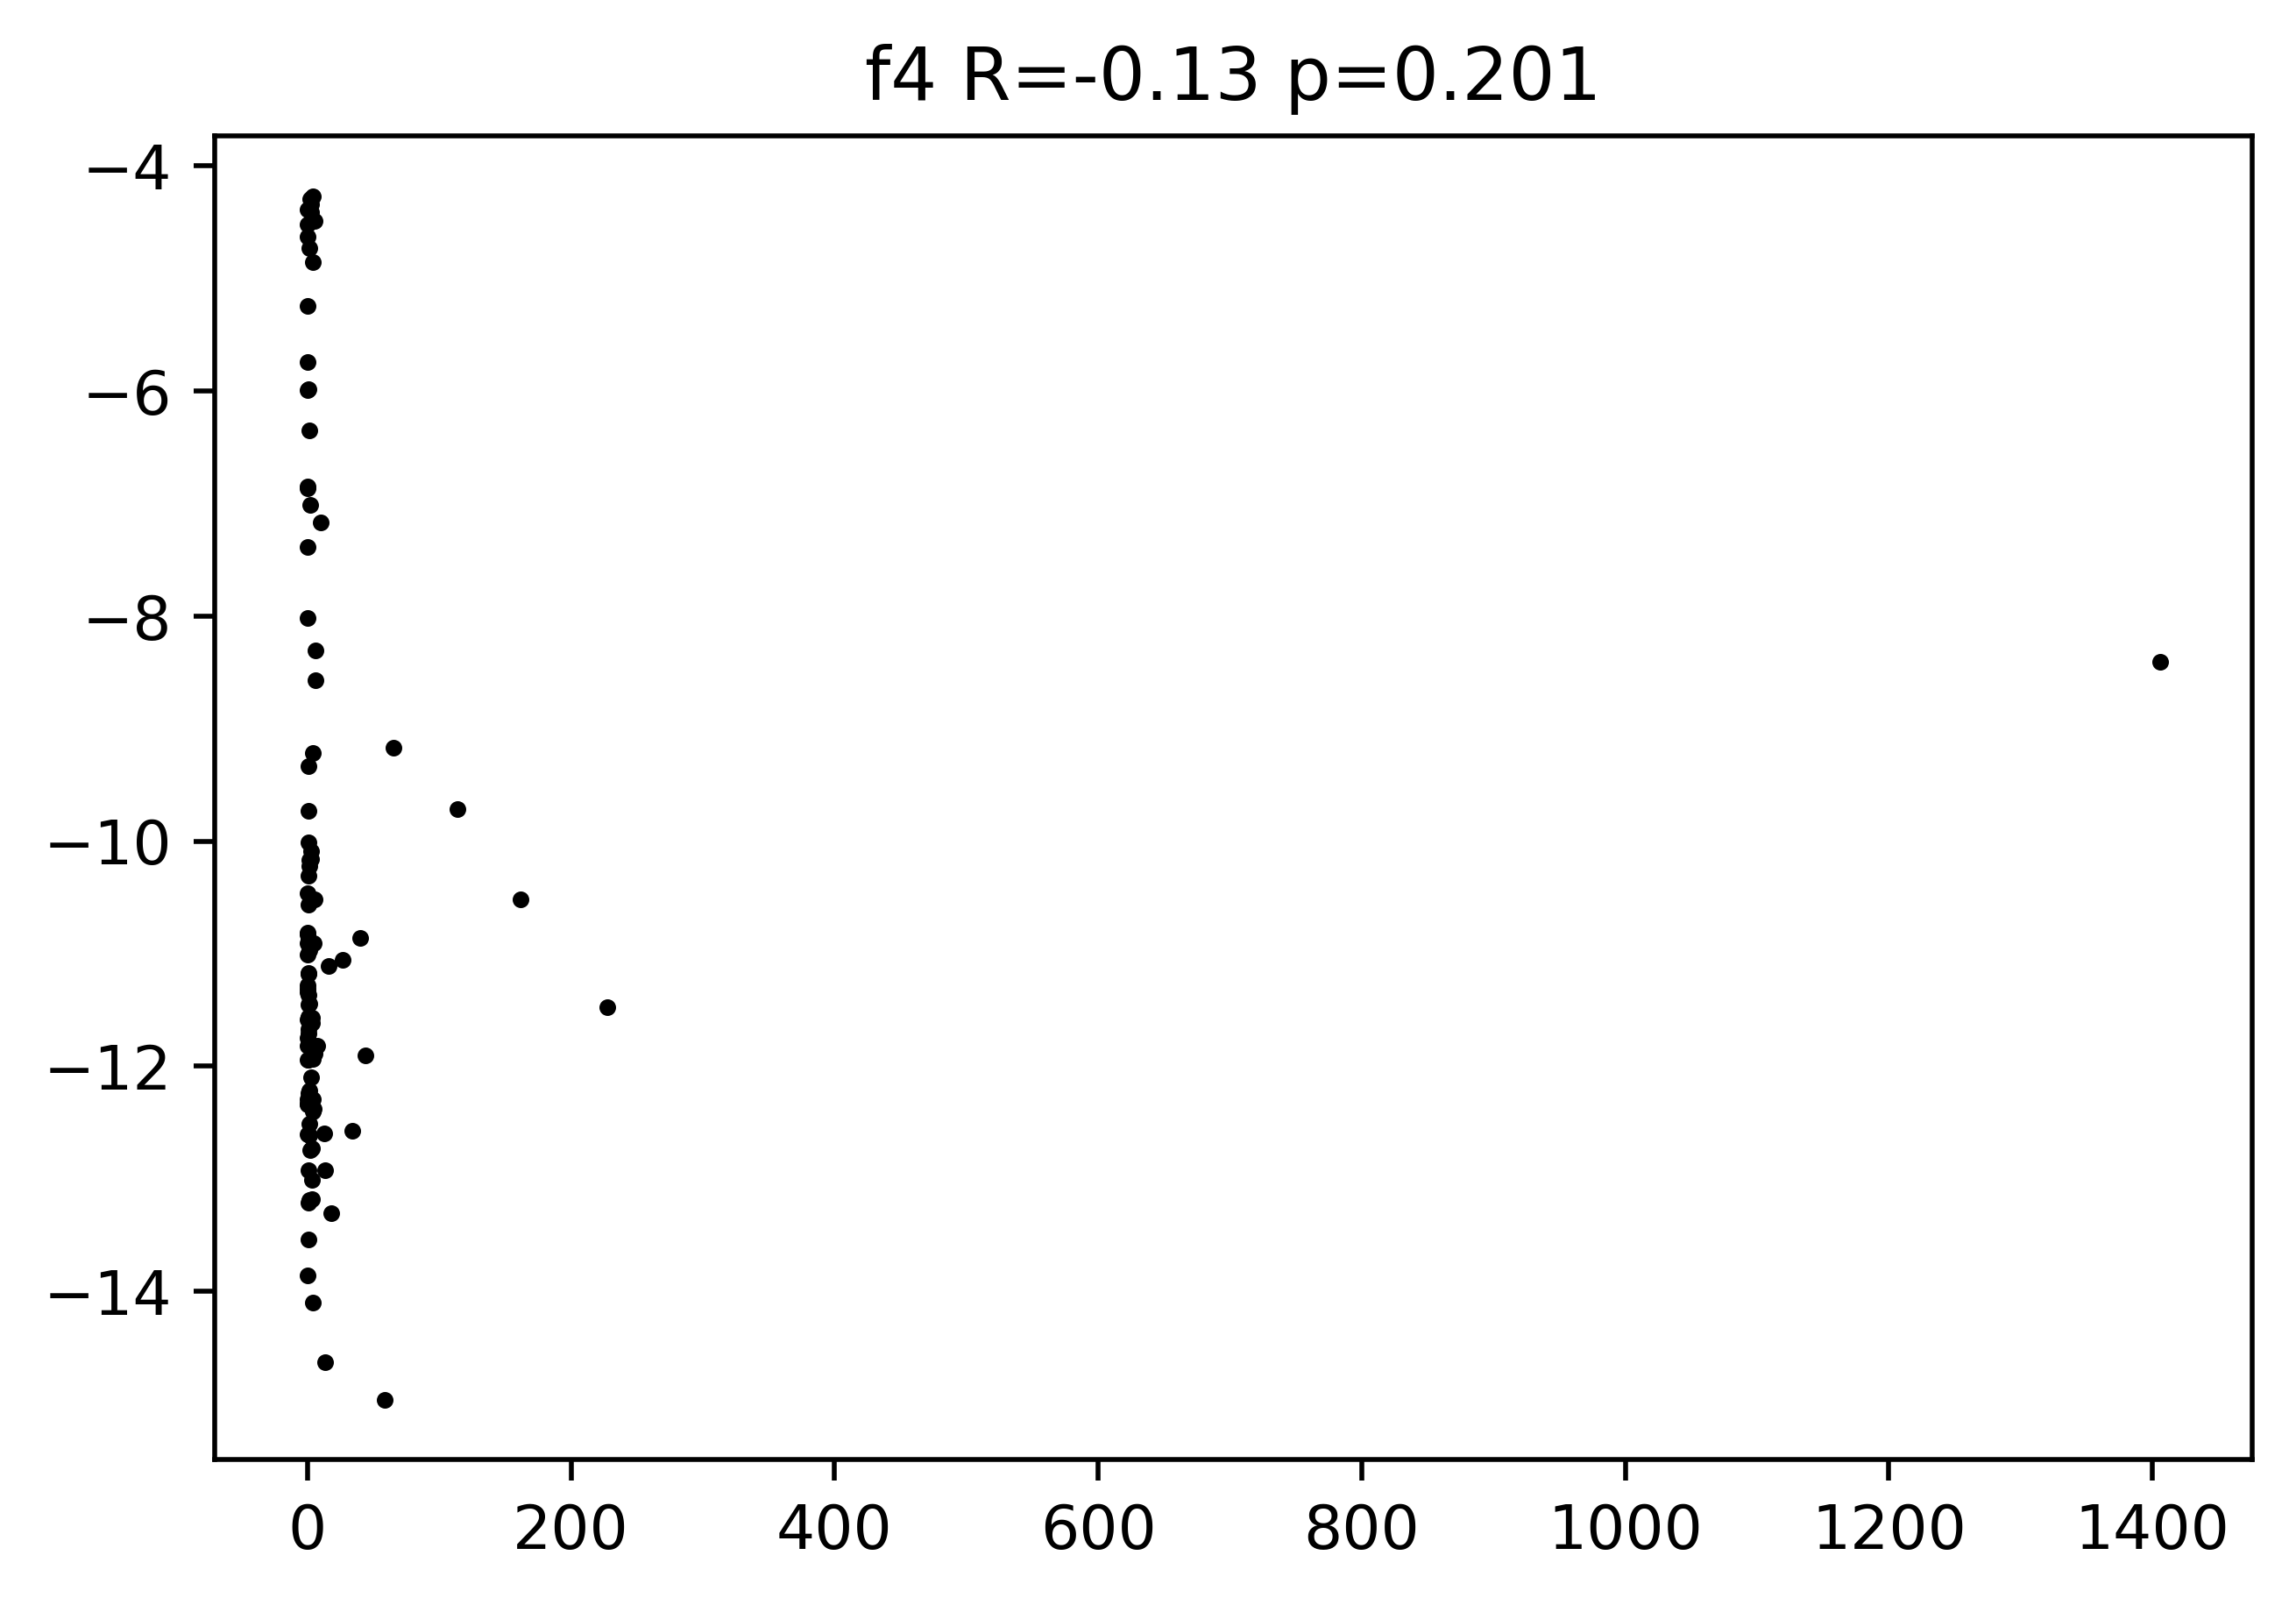

In [16]:
for x in range(pred.shape[1]):
    plt.figure()
    errs = np.abs(true[:,x]-pred[:,x])
    plt.scatter(errs,np.log10(err[:,x]),s=3,color="black")
    stat,p = stats.spearmanr(errs,err[:,x])
    plt.title("f" + str(x+1) + " R=" + str(np.round(stat,2)) + " p=" + str(np.round(p,3)))
